In [9]:
import os,pickle
import matplotlib.pylab as plt
from pynbody.sph import smooth
from scipy.interpolate import UnivariateSpline as Smooth
import numpy as np
#import argparse
import traceback
import pathlib
import sys
#parser = argparse.ArgumentParser(description='Smoothly interpolate Radial Bins for Shapes')
#args = parser.parse_args()
verbose = False
path = '/home/bk639/MorphologyMeasurements/Code'
sys.path.append(path)
#print(sys.path)

# Import the SimInfoDicts package
from SimInfoDicts.sim_type_name import sim_type_name


from scipy.ndimage import gaussian_filter1d, label
from scipy.interpolate import interp1d


# def variable_sigma(r, reff, sigma_start=10, sigma_end=3):
#     # Linear interpolation for sigma
#     return sigma_start + (sigma_end - sigma_start) * np.minimum(r / reff, 1)
#
# def gaussian_smooth(x, y, reff):
#     # Calculate variable sigma for each point
#     sigma_values = variable_sigma(x, reff)
#
#     # Apply Gaussian filter with variable sigma
#     y_smooth = np.zeros_like(y)
#     for i in range(len(y)):
#         y_smooth[i] = gaussian_filter1d(y, sigma_values[i])[i]
#
#     y_smooth = np.clip(y_smooth, 0, 1)  # Ensure values are between 0 and 1
#
#     # Create an interpolation function
#     f = interp1d(x, y_smooth, kind='cubic', fill_value='extrapolate')
#
#     # Display a warning if y values are not between 0 and 1
#     if np.any(y_smooth < 0) or np.any(y_smooth > 1):
#         print('Warning: Some smoothed values are not in the physical range [0, 1]')
#
#     # Return a callable function that clips the output between 0 and 1
#     return lambda x_new: np.clip(f(x_new), 0, 1)


from scipy.interpolate import UnivariateSpline as Smooth


def gaussian_smooth(x, y, distance=0.2, sigma=6):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Create a new array for smoothed y values
    y_smooth = np.zeros_like(y_sorted)

    for i, xi in enumerate(x_sorted):
        # Find indices of points within the specified distance
        mask = np.abs(x_sorted - xi) <= distance
        x_window = x_sorted[mask]
        y_window = y_sorted[mask]

        # Apply Gaussian smoothing to the window
        if len(y_window) > 1:
            y_smooth[i] = gaussian_filter1d(y_window, sigma)[0]
        else:
            y_smooth[i] = y_window[0]

    # Clip values between 0 and 1
    y_smooth = np.clip(y_smooth, 0, 1)

    # Create an interpolation function
    f = interp1d(x_sorted, y_smooth, kind='cubic', fill_value='extrapolate')

    # Display a warning if y values are not between 0 and 1
    if np.any(y_smooth < 0) or np.any(y_smooth > 1):
        print(
            'Warning: Some smoothed values are not in the physical range [0, 1]')

    # # Return a callable function that clips the output between 0 and 1
    # return lambda x_new: np.clip(f(x_new), 0, 1)
    return f

import numpy as np
from scipy.interpolate import UnivariateSpline

# 
# def nanfunction(x):
#     return x*0 +10

from scipy.interpolate import UnivariateSpline
def smooth_and_filter_data(rbins, ba, ca,k=5):
    s_factor=1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Print some diagnostic information
    # print(f"Total data points: {len(rbins)}")
    # print(f"Data points after NaN removal: {len(rbins_filtered)}")
    # print(f"NaN percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    n = len(rbins_filtered)
    #calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    #calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    #remove outliers
    d = 3


    mask = np.abs(ba_residuals) < d*ba_std


    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d*ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    #remove any points that are isolated in space
    #calculate the difference between each point

    diff = np.diff(rbins_filtered,prepend=0)
    #print(diff)
    #mask isolated points
    mask = diff > 1
    #print(mask)
    # print(rbins_filtered[mask])
    # print(diff[mask])
    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)
        # Print some diagnostic information
    # print(f"Data points after outlier removal: {len(rbins_filtered)}")
    # print(f"Outlier percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    #clip the function to 0,1
    ba_s_c = lambda x: np.clip(ba_s(x),0,1)
    ca_s_c = lambda x: np.clip(ca_s(x),0,1)
    
    return rbins_filtered, ba_filtered, ca_filtered, ba_s_c, ca_s_c



Calculating masses for MerianCDM feedback type.
Saving ../../Figures/3DShapesv2/r431.MerianCDM/Stars.1.png
Calculating masses for MerianCDM feedback type.
Saving ../../Figures/3DShapesv2/r431.MerianCDM/Dark.1.png
Calculating masses for MerianSIDM feedback type.
Calculating masses for MerianSIDM feedback type.
Calculating masses for MerianSIDMad feedback type.
Error loading r431.MerianSIDMad.Profiles.pickle
Traceback (most recent call last):
  File "/tmp/ipykernel_3220684/1656680838.py", line 70, in <module>
    rbins,ba,ca=Shapes[hid]['rbins'],Shapes[hid]['ba'], Shapes[hid]['ca']
                ~~~~~~^^^^^
KeyError: 1

An error processing sim r431 halo 1 type 3DShapes: 1
Calculating masses for MerianSIDMad feedback type.
Error loading r431.MerianSIDMad.Profiles.pickle
Saving ../../Figures/3DShapesv2/r431.MerianSIDMad/Dark.1.png
Calculating masses for MerianCDMad feedback type.
Error loading r431.MerianCDMad.Profiles.pickle
Traceback (most recent call last):
  File "/tmp/ipykernel_3220

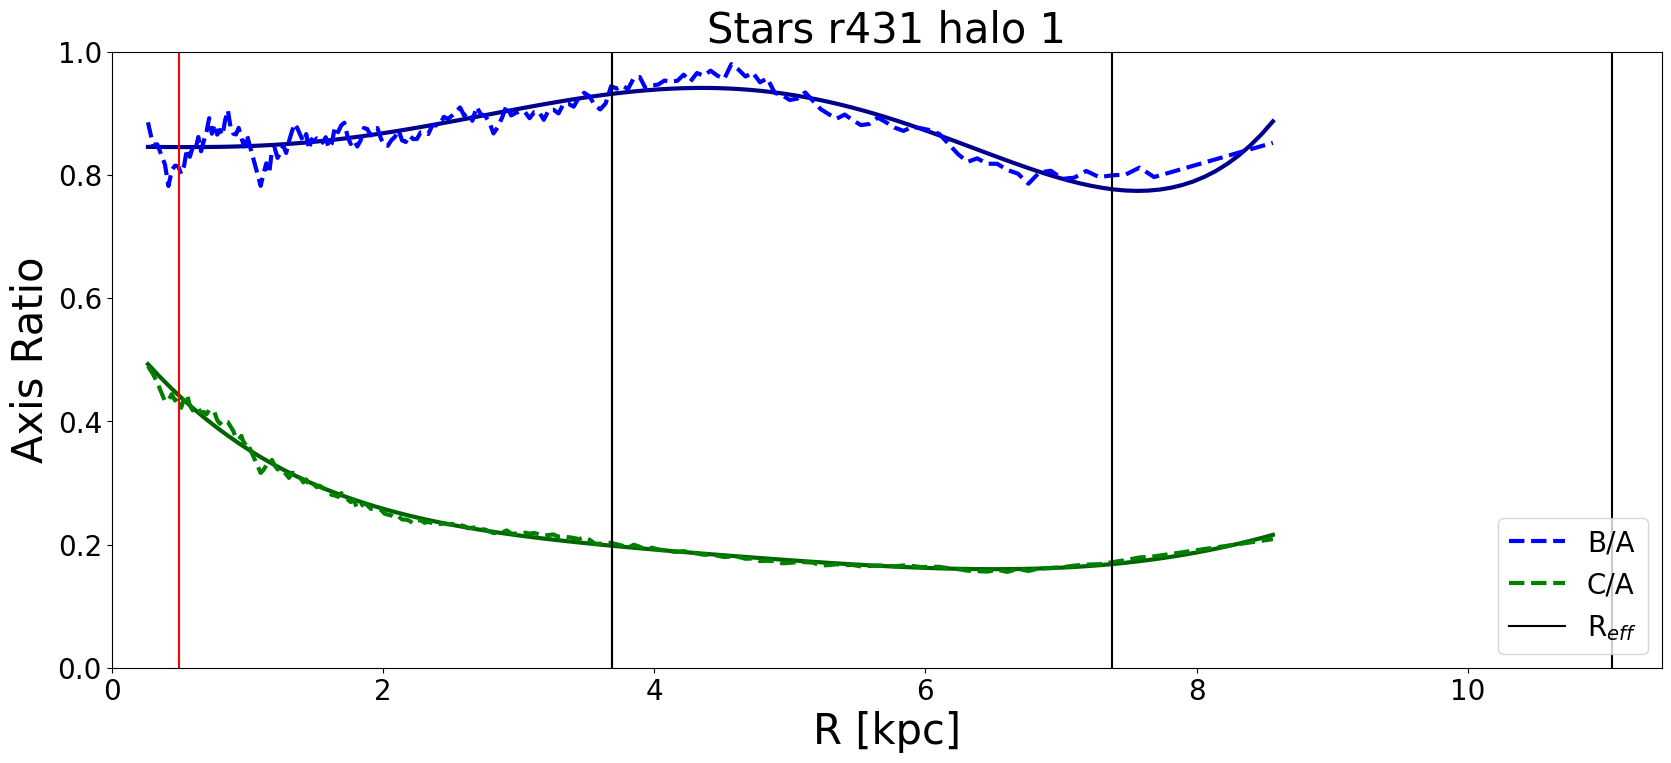

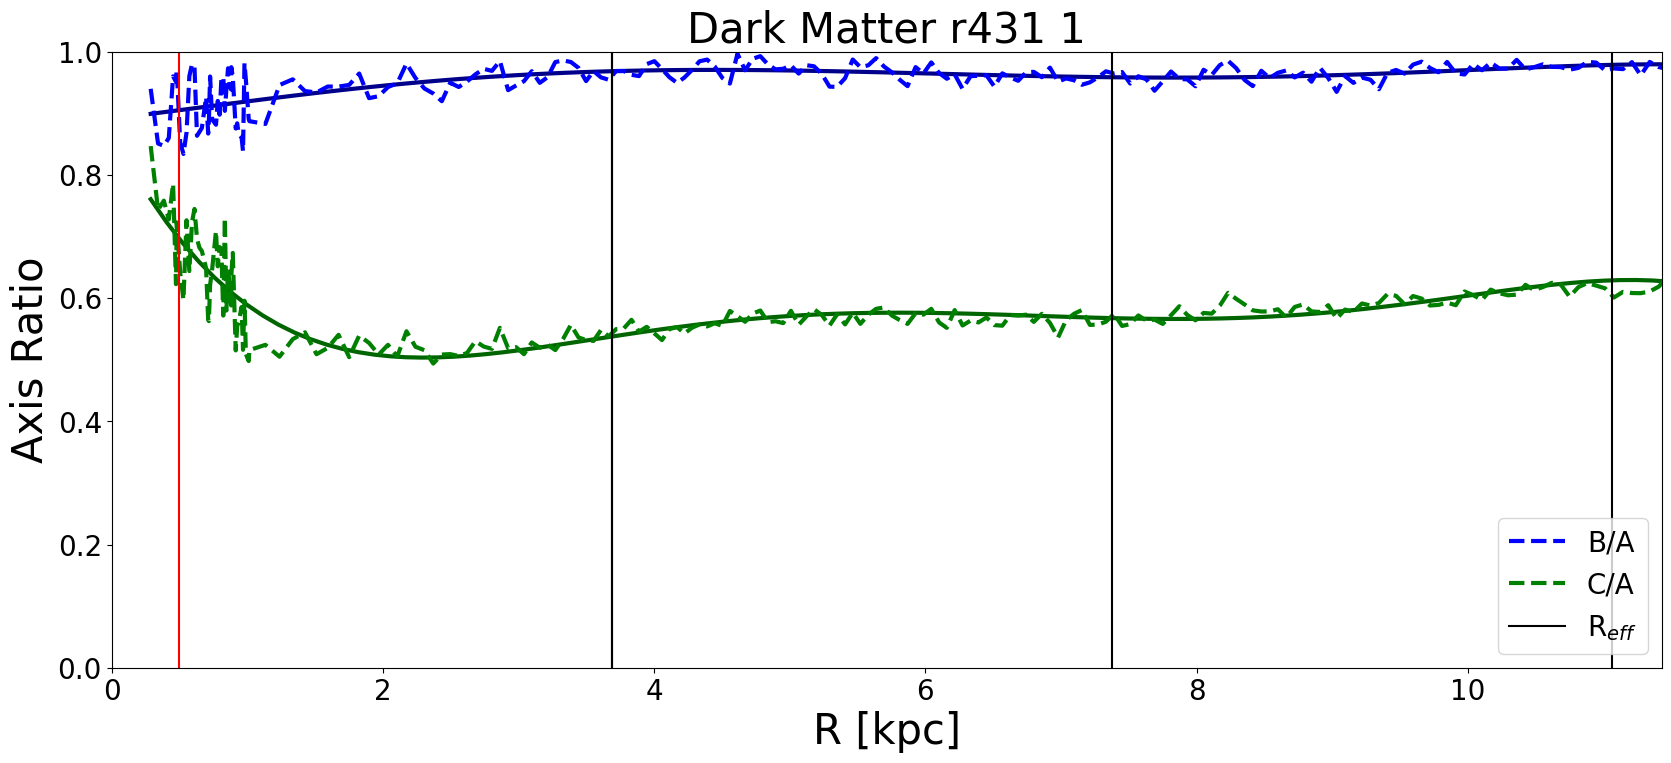

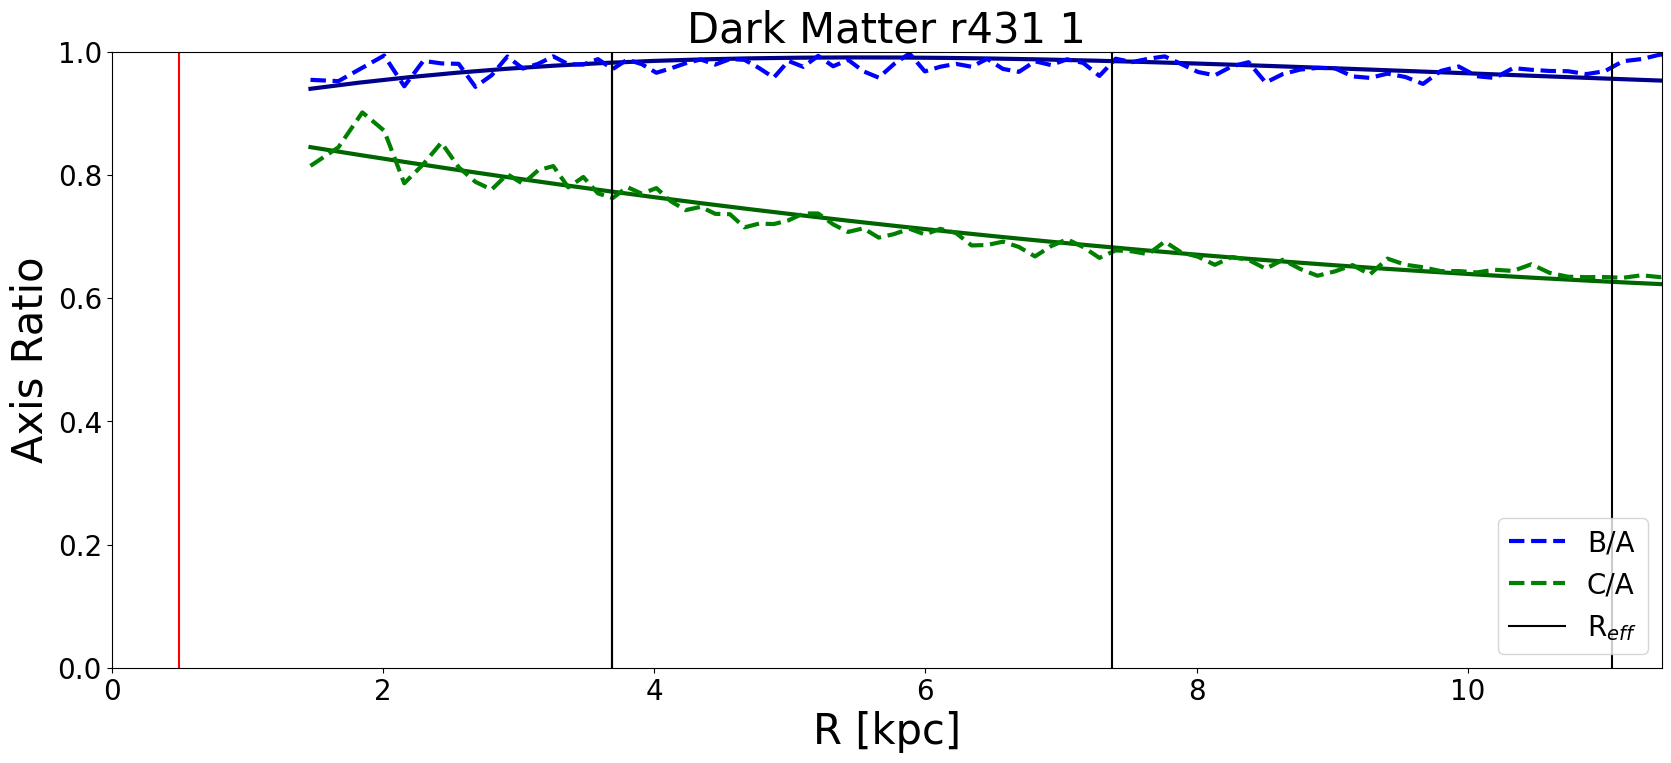

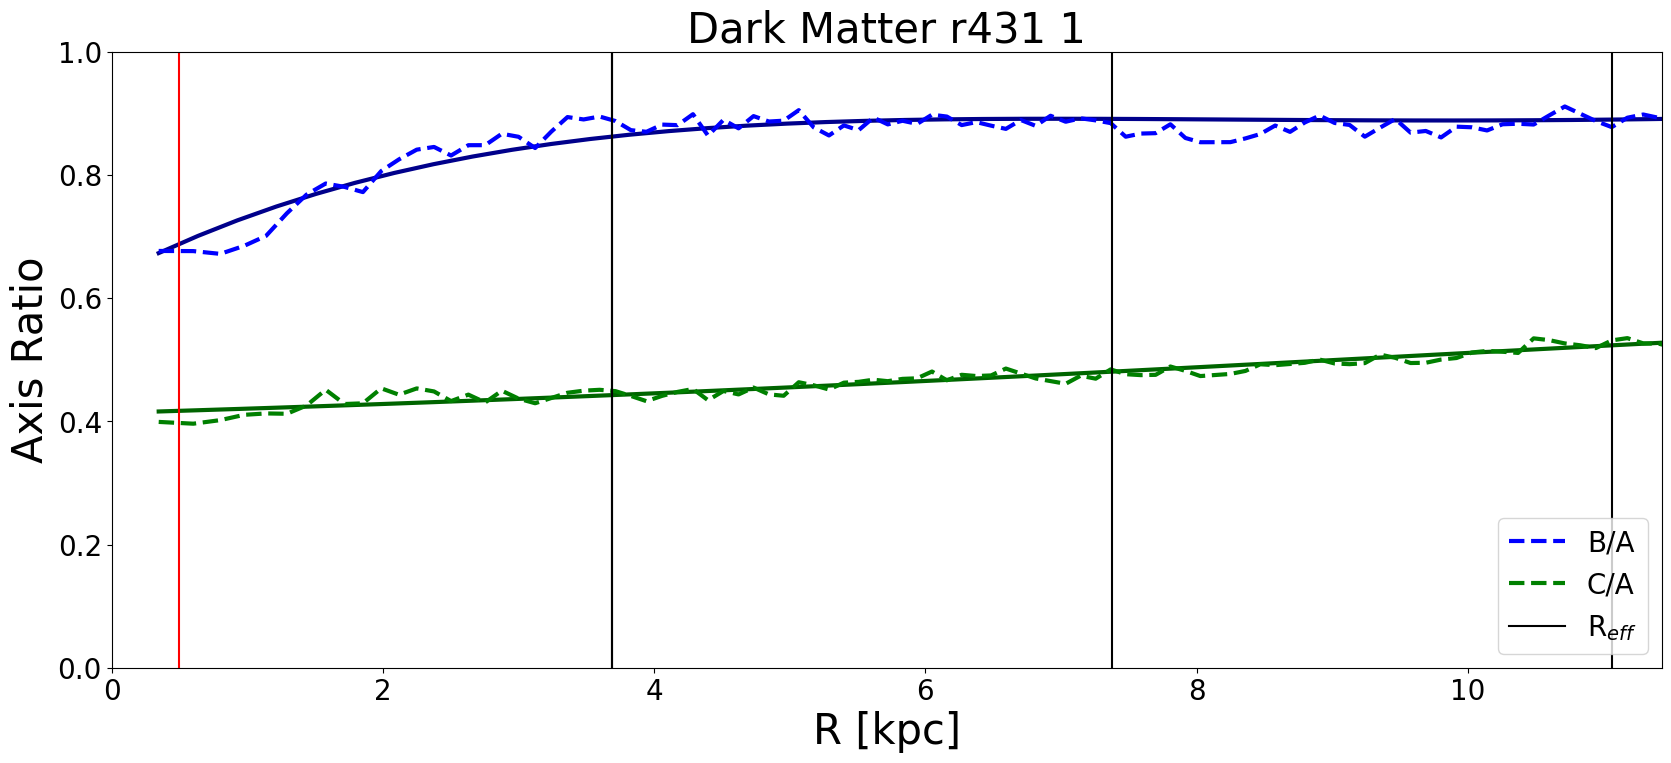

In [3]:

# Example usage:
# rbins_filtered, ba_filtered, ca_filtered, ba_smooth, ca_smooth = smooth_and_filter_data(rbins, ba, ca)

# Example usage:
# rbins, ba, ca = your_data_here
# rbins_filtered, ba_filtered, ca_filtered, ba_smooth, ca_smooth = smooth_and_filter_data(rbins, ba, ca)


# loop,remake=True,False
# while loop:
#     rem = input('Remake Image Directory: Figures/3DShapes/- (y/n): ')
#     if rem in ['y','n']:
#         loop = False
#         if rem=='y': remake = True
# if remake:
#     #os.system('rmdir -f ../Figures/3DShapes')
#     #os.system('mkdir ../figures/3DShapes')
#     for sim in SimInfo:
#         os.system(f'mkdir ../../Figures/3DShapes/{sim}.{feedback}/')
windows = {
    '3DShapes':{
    'cptmarvel-10':[.65,2],
    'elektra-3':[.4,.8],
    'storm-2':[5,40],
    'storm-8':[3,10],
    'rogue-7':[.8,1],
    'rogue-8':[0,1],
    },
    'DMShapes':{

    }
}



sim_type_name['BWMDC'] = False
sim_type_name['MerianCDM'] = True
#add path to sys.path for jupyter notebook
#path /home/bk639/MorphologyMeasurements/SimInfoDicts

#only make for a few sims
sims_to_use = ['r431','r563','r850']
#sims_to_use = ['r634']


for feedback, use_sim in sim_type_name.items():
    for t in ['3DShapes','DMShapes']:
        #if feedback=='BWMDC':
            #continue
        if use_sim:
            print(f'Calculating masses for {feedback} feedback type.')
            pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
            if os.path.exists(pickle_path):
                SimInfo = pickle.load(open(pickle_path, 'rb'))
                #add a check to see if the mass file already exists, if it does, we need to make sure it has all the current sims
                for sim in SimInfo:
                    if sim not in sims_to_use:
                        continue
                    try:
                        Shapes = pickle.load(open(f'../../Data/{sim}.{feedback}.{t}.pickle','rb'))
                    except FileNotFoundError:
                        print(f'Error loading {sim}.{feedback}.{t}.pickle')
                    try:
                        Profiles = pickle.load(open(f'../../Data/{sim}.{feedback}.Profiles.pickle','rb'))
                    except FileNotFoundError:
                        print(f'Error loading {sim}.{feedback}.Profiles.pickle')
                    for hid in SimInfo[sim]['goodhalos']:
                        #for t in ['DMShapes','3DShapes']:
                            try:
                                rbins,ba,ca=Shapes[hid]['rbins'],Shapes[hid]['ba'], Shapes[hid]['ca']
                                reffs = []
                                if len(rbins)>0:
                                    #print('halo',hid)

                                    for angle in Profiles[str(hid)]:
                                        try:
                                            reffs.append(Profiles[str(hid)][angle]['Reff'])
                                        except IndexError:
                                            if verbose:
                                                print(f'IndexError angle {angle} for halo {hid} in {sim}.{feedback}.Profiles.pickle')
                                        break

                                    f,ax=plt.subplots(1,1,figsize=(20,8))
                                    ax.set_xlim([0,max(rbins)])
                                    ax.set_ylim([0,1])
                                    ax.set_xlabel('R [kpc]',fontsize=30)
                                    ax.set_ylabel('Axis Ratio',fontsize=30)
                                    ax.tick_params(which='both',labelsize=20)
                                    lw = 3

                                    try:
                                        r_bins, ba_f, ca_f, ba_s, ca_s = smooth_and_filter_data(rbins, ba, ca)
                                        r_smooth = np.linspace(min(r_bins),max(r_bins),100)
                                        ax.plot(r_smooth,ba_s(r_smooth),c='darkblue',linestyle='-',lw=lw)
                                        ax.plot(r_smooth,ca_s(r_smooth),c='darkgreen',linestyle='-',lw=lw)
                                        #print(ba,ba_s(rbins))
                                        #Shapes[str(hid)]['ba_smooth'] = ba_s
                                        #Shapes[str(hid)]['ca_smooth'] = ca_s
                                    except Exception as e:
                                        print(f"An error occurred during smoothing sim {sim} halo {hid} type {t}: {e}")
                                        print(traceback.format_exc())


                                    ax.plot(r_bins,ba_f,c='b',label='B/A',lw=lw,ls='--')
                                    ax.plot(r_bins,ca_f,c='g',label='C/A',lw=lw,ls='--')
                                    ax.set_xlim([0,3.1*reffs[0]])
                                    if t == '3DShapes':
                                        title = f'Stars {sim} halo {hid}'
                                    else:
                                        title = f'Dark Matter {sim} {hid}'
                                    ax.set_title(f'{title}',fontsize=30)
                                    #add horizontal lines at 0.5 kpc, 1 * reffs[0]], 2 * reffs[0]], 3 * reffs[0]]
                                    for i in range(1,4):
                                        ax.axvline(i*reffs[0],c='k',alpha=1)
                                    ax.axvline(.5,c='r',alpha=1)
                                    #ba_s,ca_s = gaussian_smooth(rbins,ba,.3,10),gaussian_smooth(rbins,ca,.3,10)





                                    ax.axvline(reffs[0],c='k',alpha=1,label=r'R$_{eff}$')

                                    ax.legend(loc='lower right',prop={'size':20})
                                    fname='Stars' if t=='3DShapes' else 'Dark'
                                    #create folder if it doesn't exist
                                    if not os.path.exists(f'../../Figures/3DShapesv2/{sim}.{feedback}/'):
                                        os.makedirs(f'../../Figures/3DShapesv2/{sim}.{feedback}/')
                                    filename = f'../../Figures/3DShapesv2/{sim}.{feedback}/{fname}.{hid}.png'
                                    print(f'Saving {filename}')
                                    f.savefig(filename,bbox_inches='tight',pad_inches=.1)
                                    #plt.close()







                            except Exception as e:
                                print(traceback.format_exc())
                                print(f"An error processing sim {sim} halo {hid} type {t}: {e}")
                            break
                    break




                        #pickle.dump(Shapes,open(f'../../Data/{sim}.{feedback}.{t}.pickle','wb'))
print('Smoothing Done')

Calculating masses for MerianCDM feedback type.
Saving ../../Figures/CombinedShapes/r431.MerianCDMShapes.1.png
Saving ../../Figures/CombinedShapes/r563.MerianCDMShapes.1.png
Saving ../../Figures/CombinedShapes/r850.MerianCDMShapes.1.png
Calculating masses for MerianSIDMad feedback type.
Error loading pickle files for r431: [Errno 2] No such file or directory: '../../Data/r431.MerianSIDMad.Profiles.pickle'
Calculating masses for MerianCDMad feedback type.
Error loading pickle files for r431: [Errno 2] No such file or directory: '../../Data/r431.MerianCDMad.Profiles.pickle'
Calculating masses for BWMDC feedback type.


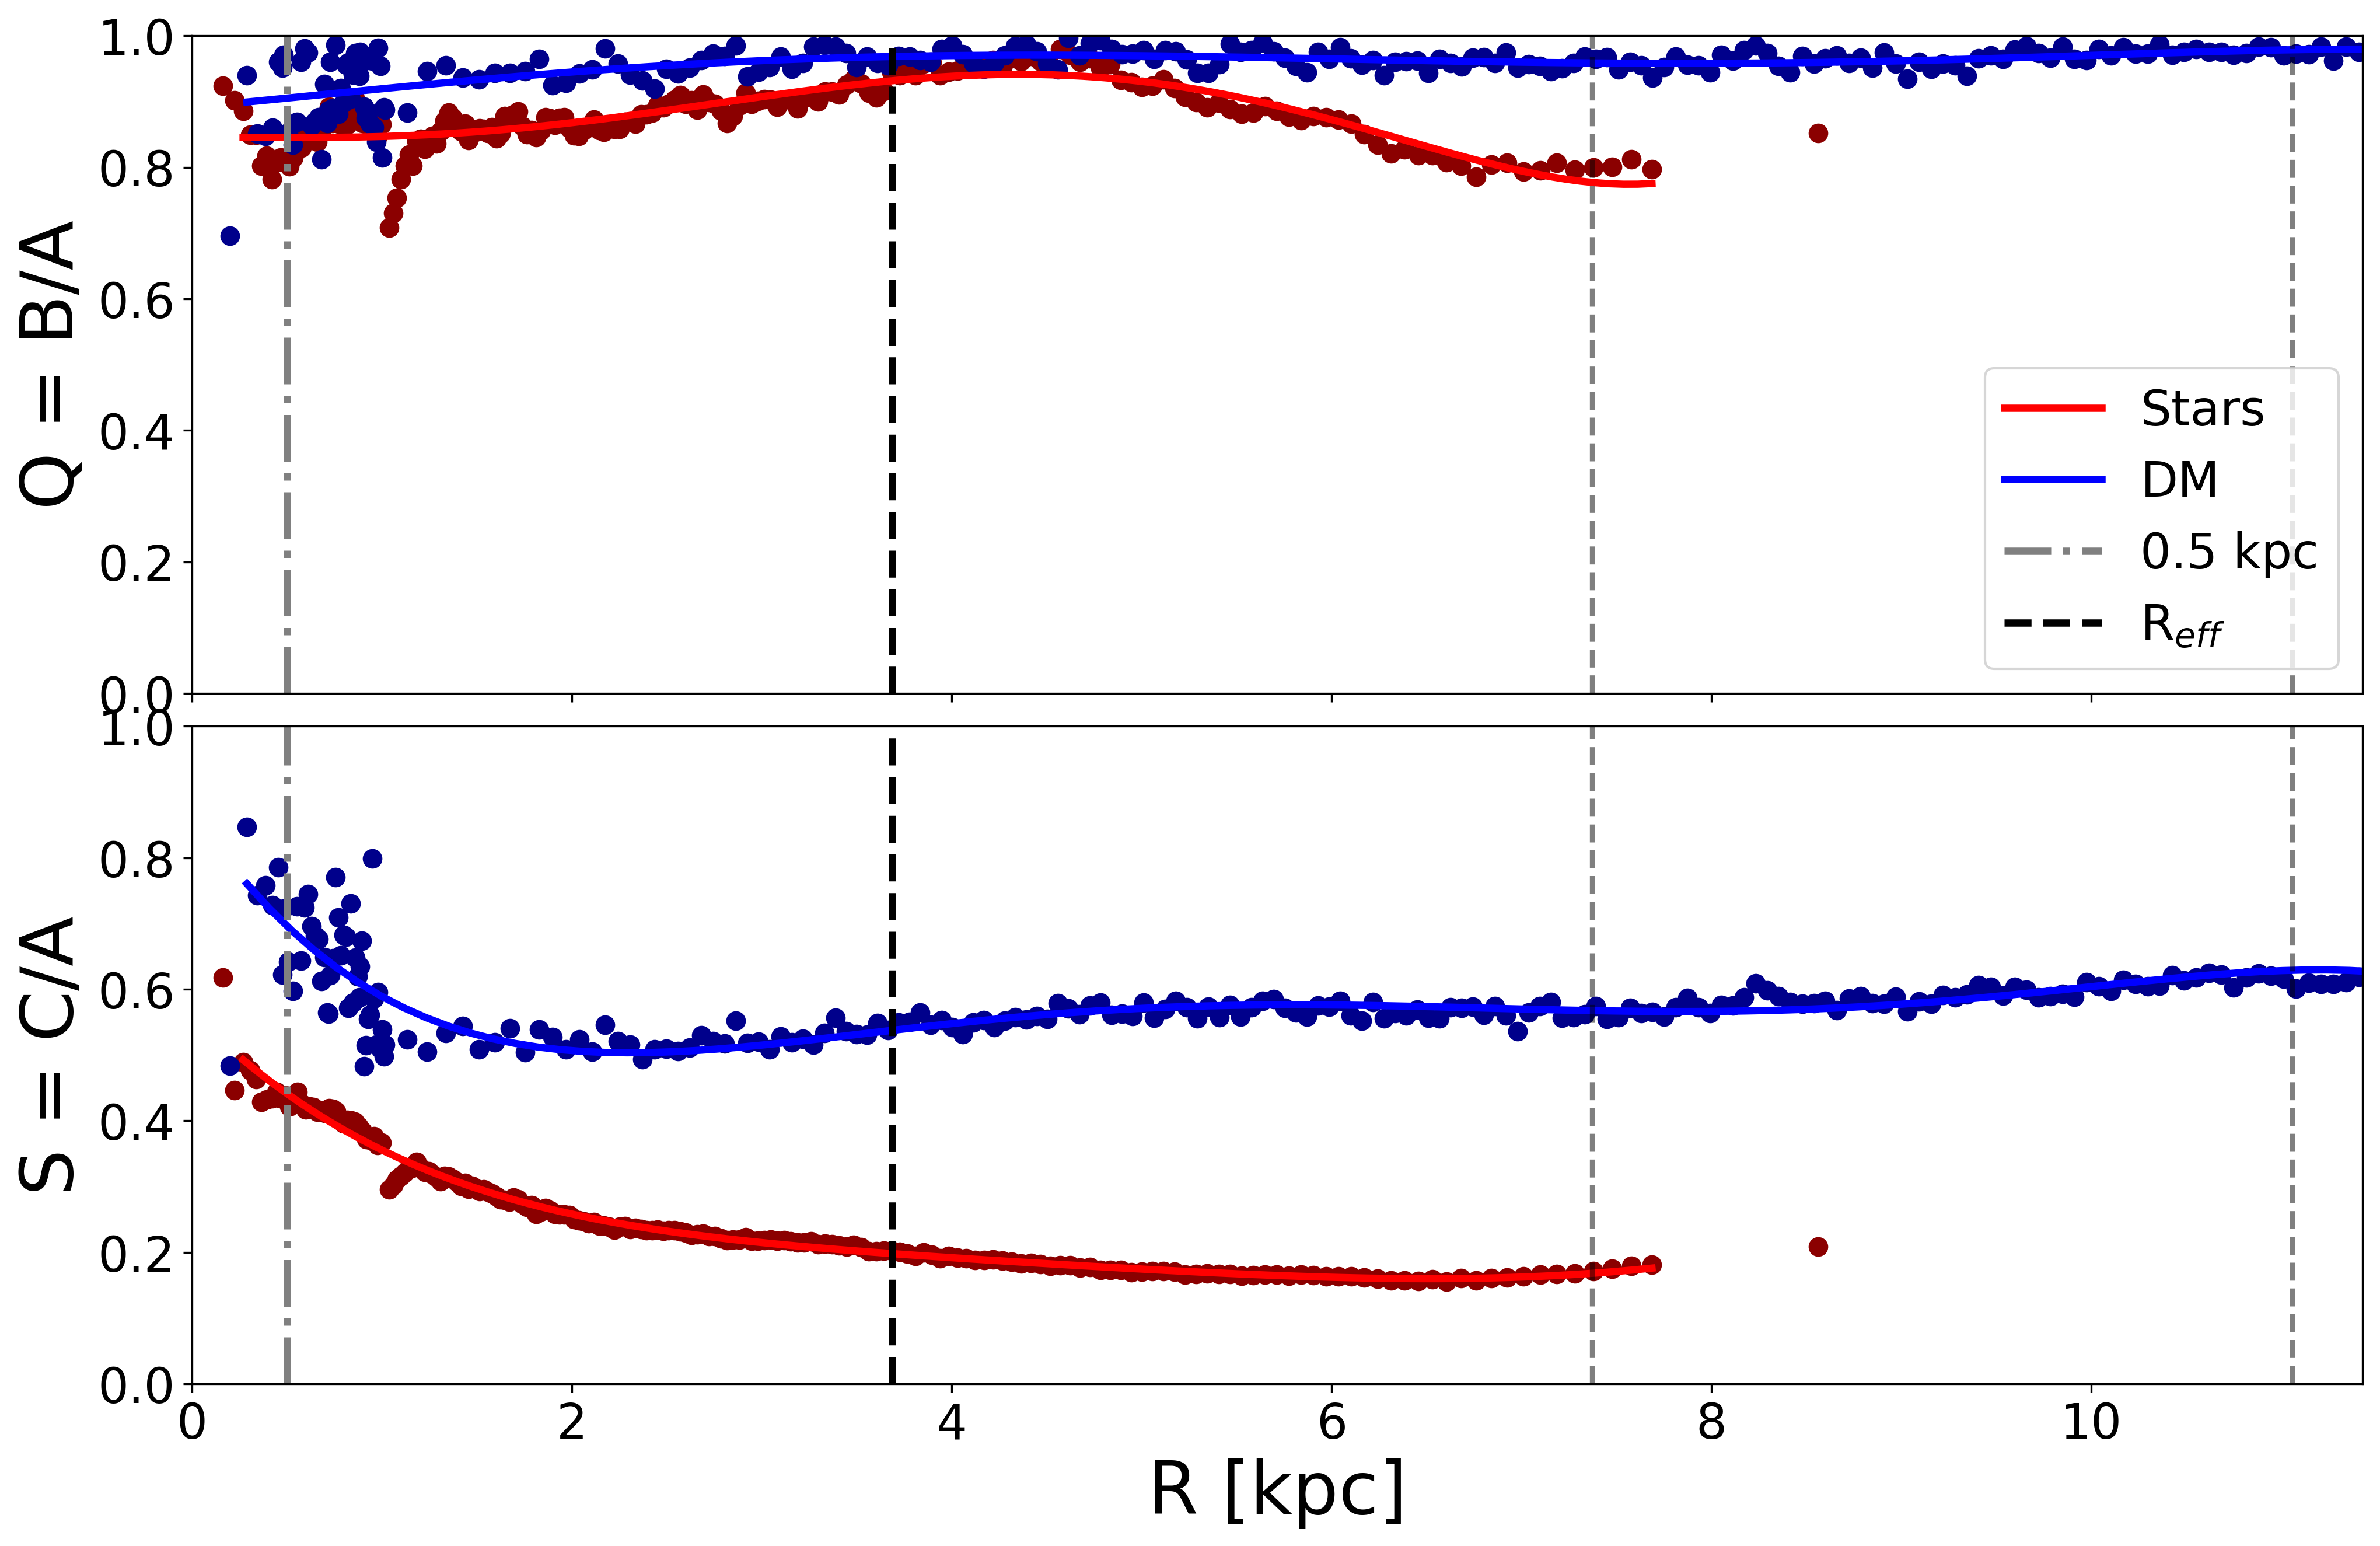

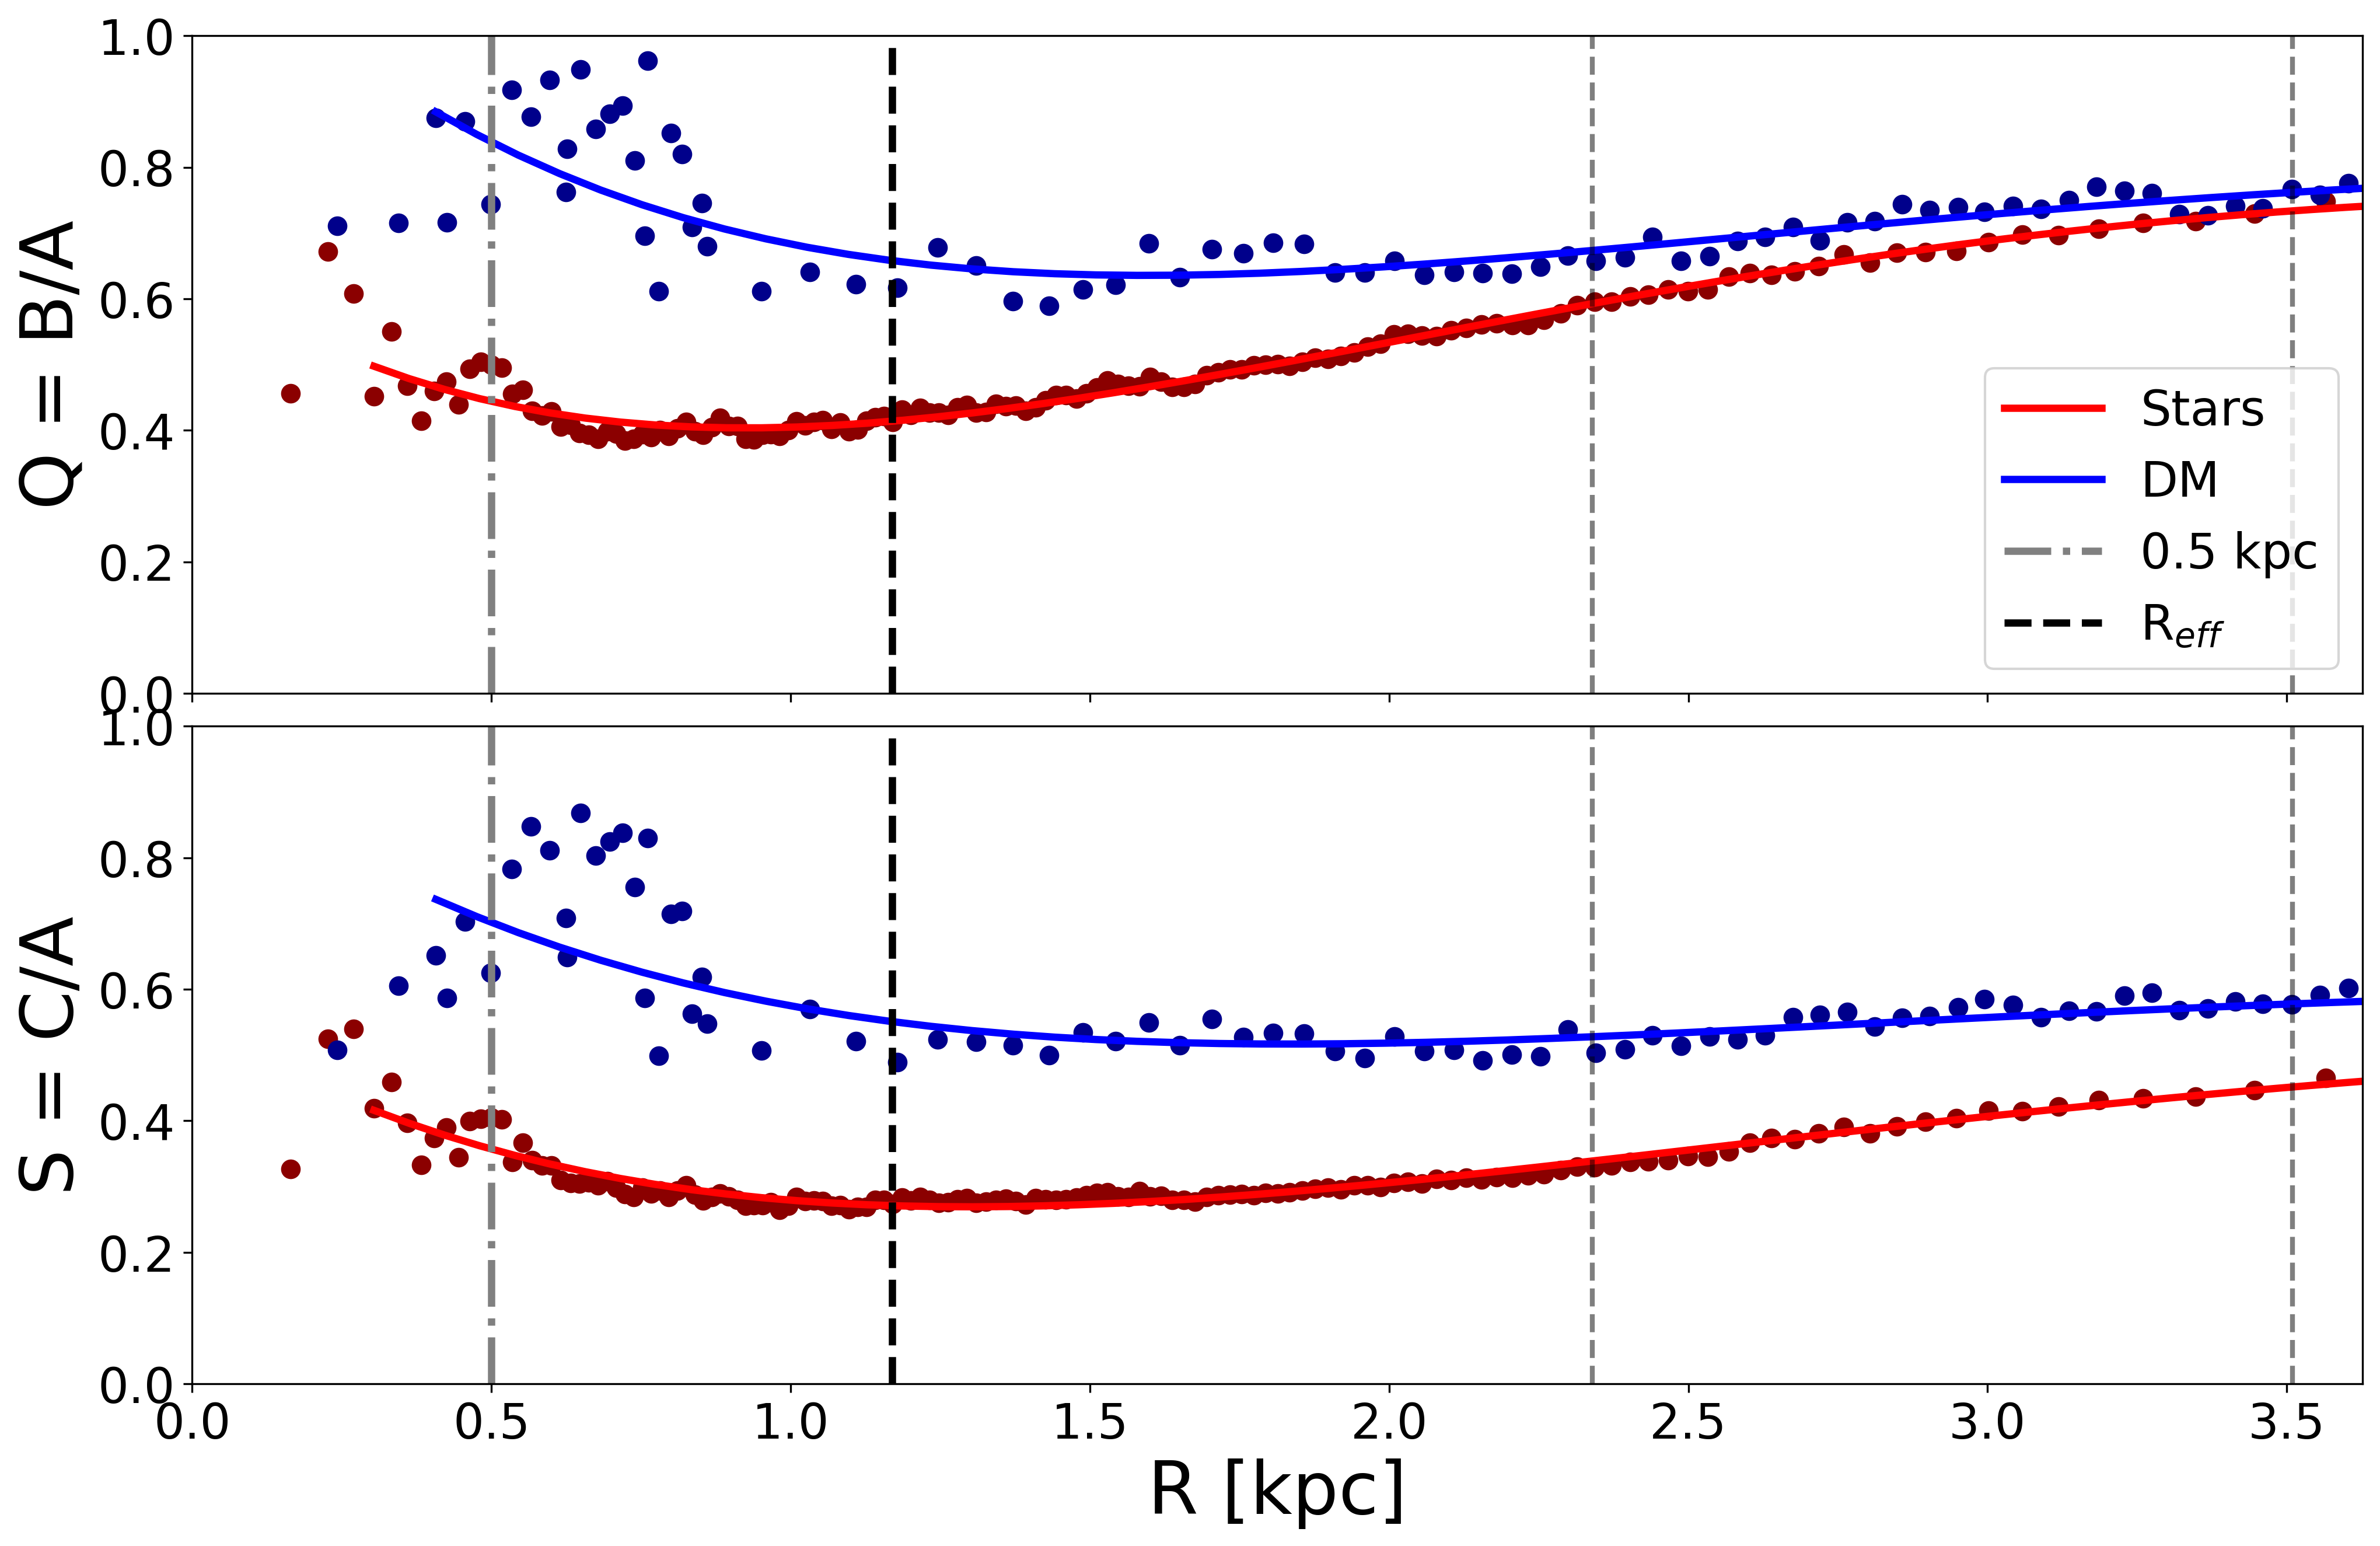

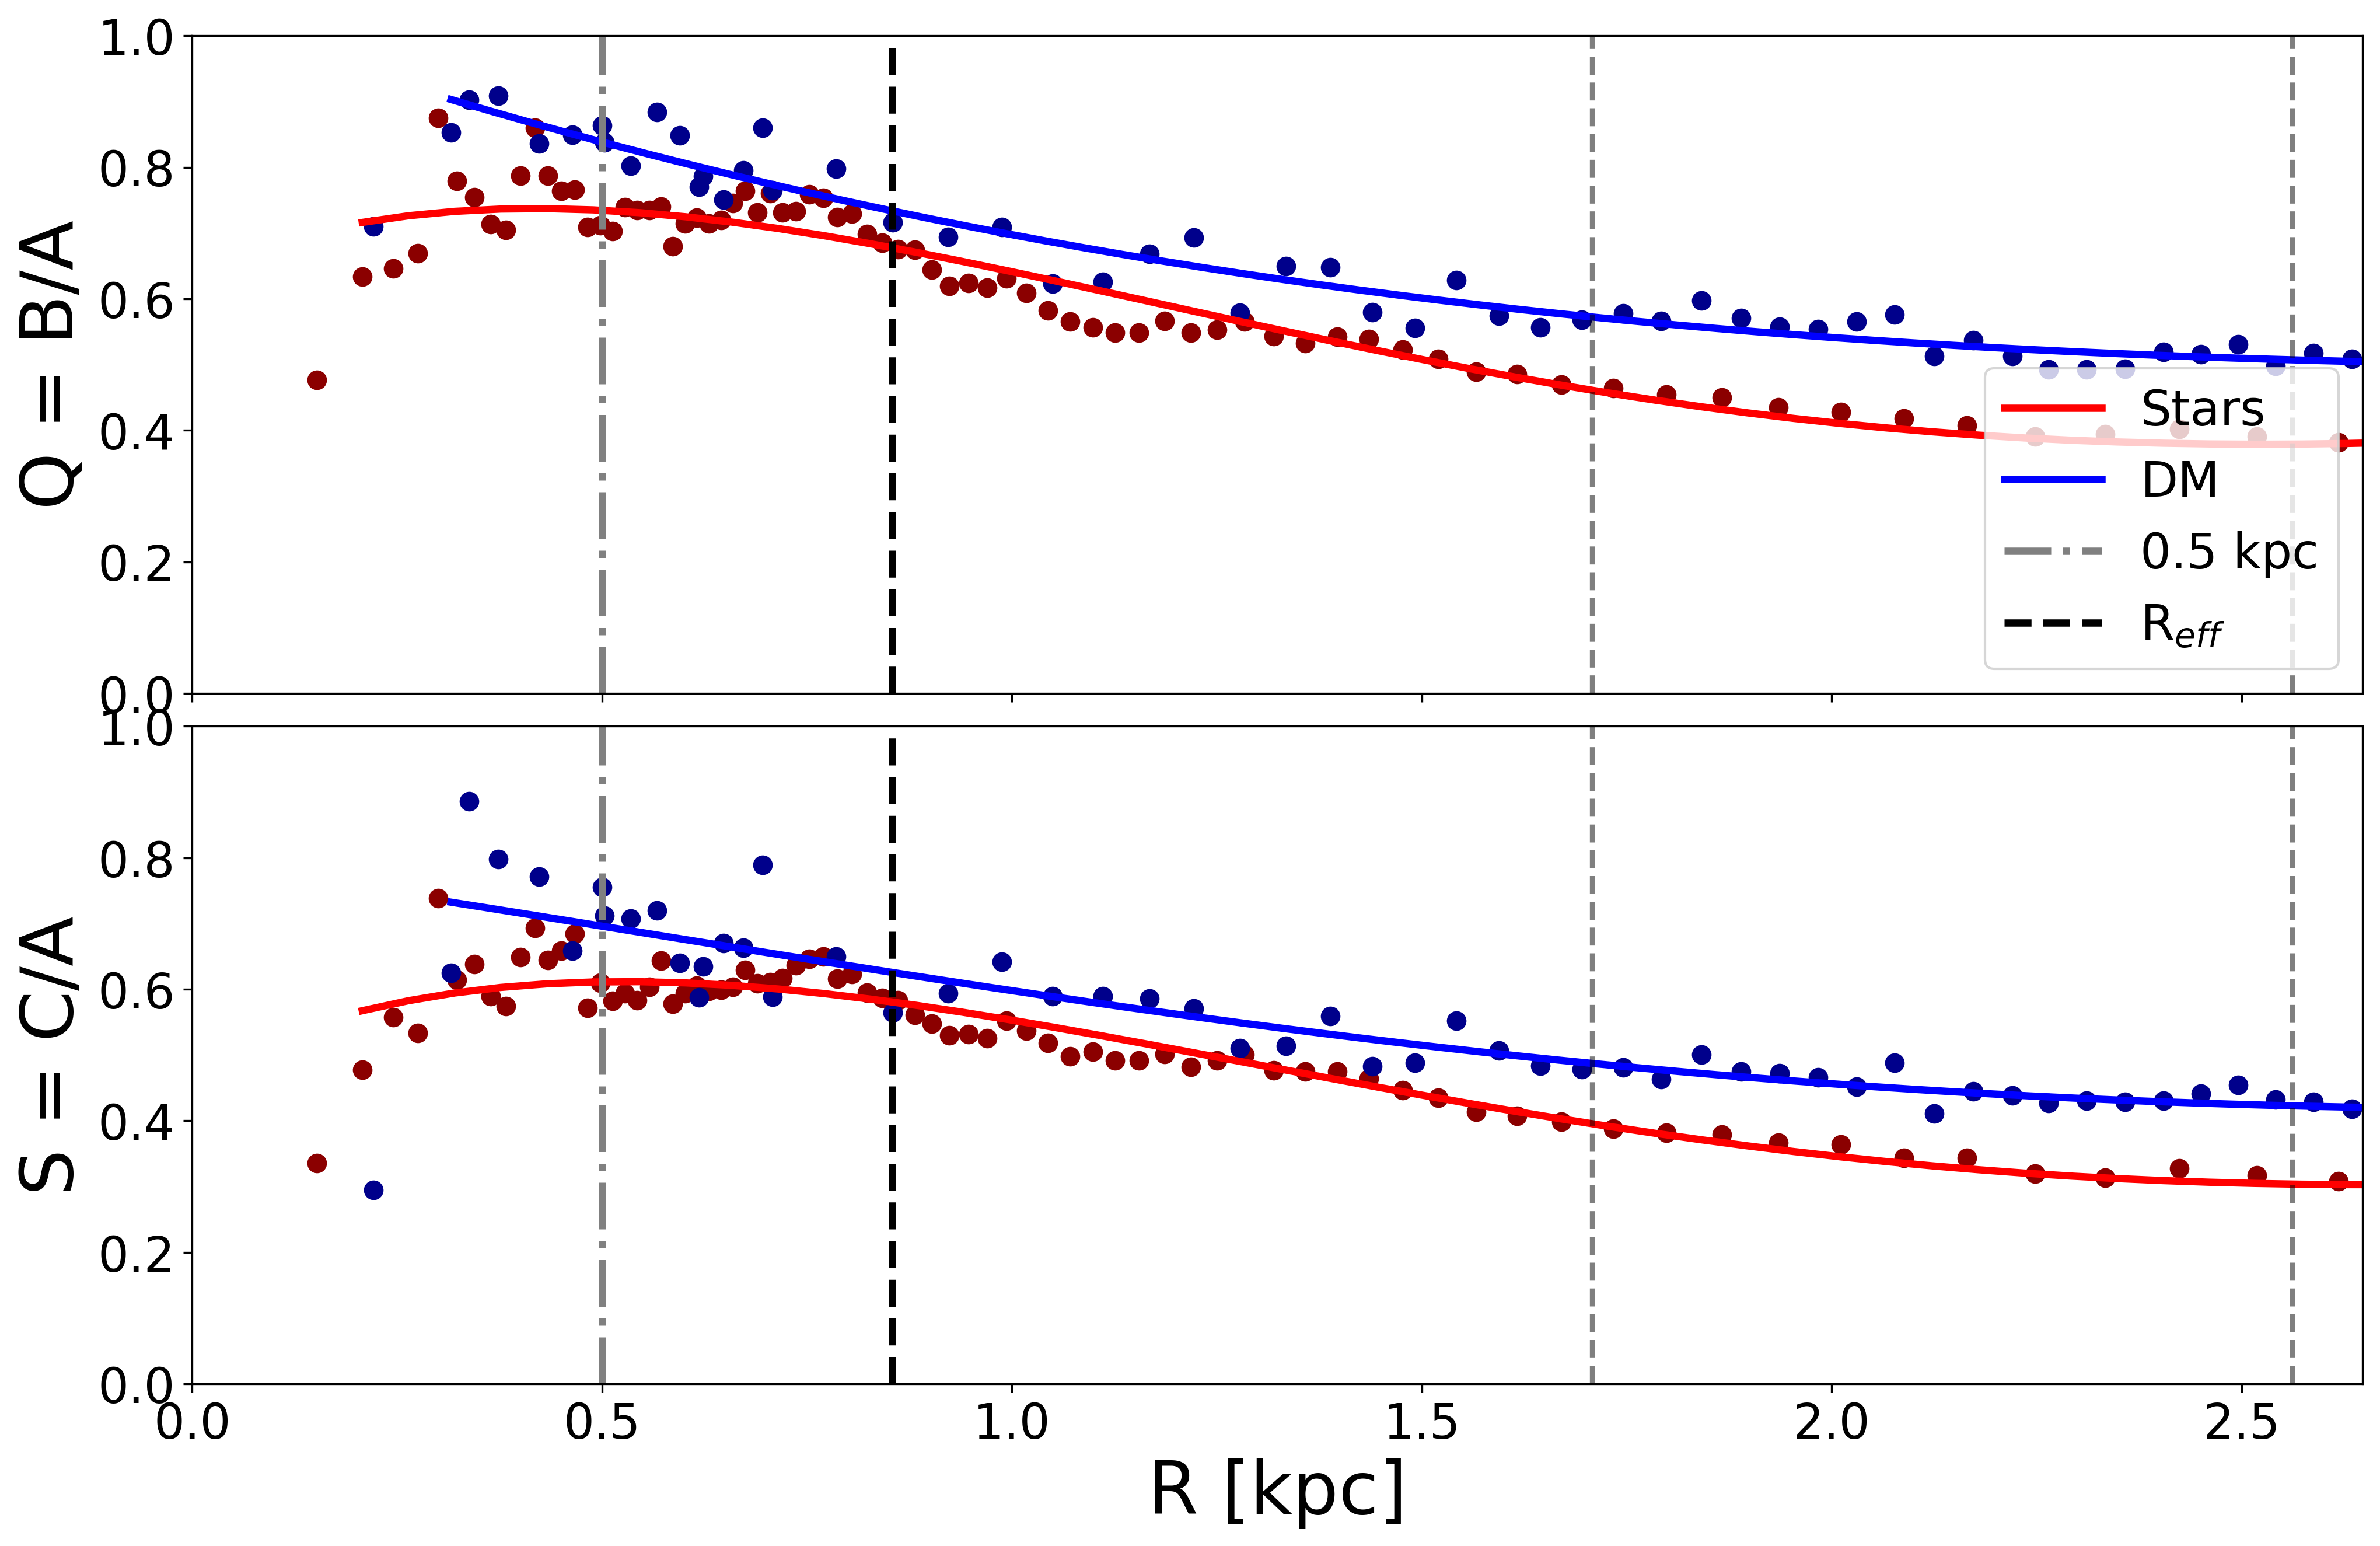

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import traceback
from scipy.interpolate import interp1d
from SimInfoDicts.sim_type_name import sim_type_name

sim_type_name['BWMDC'] = True
sim_type_name['MerianCDM'] = True
sim_type_name['MerianSIDM'] = False
#sims_to_use = ['r597.romulus25si2s50v35']
sims_to_use = ['r431','r563','r850']

def plot_combined_shapes(SimInfo, feedback, sims_to_use, verbose=False):
    for sim in SimInfo:
        if sim not in sims_to_use:
            continue

        try:
            DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.DMShapes.pickle', 'rb'))
            StarShapes = pickle.load(open(f'../../Data/{sim}.{feedback}.3DShapes.pickle', 'rb'))
            Profiles = pickle.load(open(f'../../Data/{sim}.{feedback}.Profiles.pickle', 'rb'))
        except FileNotFoundError as e:
            print(f'Error loading pickle files for {sim}: {e}')
            continue

        for hid in SimInfo[sim]['goodhalos']:
            try:
                dm_rbins, dm_ba, dm_ca = DMShapes[hid]['rbins'], DMShapes[hid]['ba'], DMShapes[hid]['ca']
                star_rbins, star_ba, star_ca = StarShapes[hid]['rbins'], StarShapes[hid]['ba'], StarShapes[hid]['ca']
                r_80 = StarShapes[hid]['r_80']

                reffs = []
                for angle in Profiles[str(hid)]:
                    try:
                        reffs.append(Profiles[str(hid)][angle]['Reff'])
                    except IndexError:
                        if verbose:
                            print(f'IndexError angle {angle} for halo {hid} in {sim}.{feedback}.Profiles.pickle')
                    break

                if len(dm_rbins) > 0 and len(star_rbins) > 0:
                    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,dpi=300)
                    axes = [ax1, ax2]
                    #remove hspace
                    plt.subplots_adjust(hspace=0.05)
                    ratios = ['B/A', 'C/A']
                    colors = {'DM': ['blue', 'darkblue'], 'Stars': ['red', 'darkred']}
                    s = 50

                    #get star data
                    k = 5
                    if sim == 'r431':
                        k = 5
                    r_bins, ba_f, ca_f, ba_s, ca_s = smooth_and_filter_data(star_rbins, star_ba, star_ca,k = k)
                    if sim == 'r431':
                        r_bins = r_bins[0:-1]
                    #print(star_rbins)
                    r_smooth = np.linspace(min(r_bins), max(r_bins), 100)
                    ax1.plot(r_smooth, ba_s(r_smooth), c=colors['Stars'][0], linestyle='-', lw=3, label='Stars')
                    ax2.plot(r_smooth, ca_s(r_smooth), c=colors['Stars'][0], linestyle='-', lw=3)
                    #ax1.plot(star_rbins, star_ba, c=colors['Stars'][1],label = 'Stars Raw', lw=3, ls='--')
                    #ax2.plot(star_rbins, star_ca, c=colors['Stars'][1], lw=3, ls='--')
                    #raw data scatter
                    ax1.scatter(star_rbins, star_ba, c=colors['Stars'][1], s=s)
                    ax2.scatter(star_rbins, star_ca, c=colors['Stars'][1], s=s)

                    #get dark matter data
                    r_bins, ba_f, ca_f, ba_s, ca_s = smooth_and_filter_data(dm_rbins, dm_ba, dm_ca)
                    r_smooth = np.linspace(min(r_bins), max(r_bins), 100)
                    ax1.plot(r_smooth, ba_s(r_smooth), c=colors['DM'][0], linestyle='-', lw=3, label='DM')
                    ax2.plot(r_smooth, ca_s(r_smooth), c=colors['DM'][0], linestyle='-', lw=3)
                    # ax1.plot(dm_rbins, dm_ba, c=colors['DM'][1], label = 'DM Raw', lw=3, ls='--')
                    # ax2.plot(dm_rbins, dm_ca,c=colors['DM'][1], lw=3, ls='--')
                    ax1.scatter(dm_rbins, dm_ba, c=colors['DM'][1], s=s)
                    ax2.scatter(dm_rbins, dm_ca, c=colors['DM'][1], s=s)
                    #ax1.set_xscale('log')



                    for ax in (ax1, ax2):
                        for j in range(2, 4):
                            ax.axvline(j*reffs[0], c='k', alpha=0.5,lw = 2,ls = '--')
                        ax.axvline(0.5, c='gray', alpha=1, lw = 3, ls = '-.', label='0.5 kpc')
                        ax.axvline(reffs[0], c='k', alpha=1, label=r'R$_{eff}$', lw = 3, ls = '--')
                        #ax1.set_title(f'{sim} halo {hid}', fontsize=30)
                        ax2.set_xlabel('R [kpc]', fontsize=30)
                        #ax.legend(loc='lower right', prop={'size': 20})
                        ax.set_ylim([0, 1])
                        ax.tick_params(which='both',labelsize=20)
                        #ax.axvline(r_80, c=colors['Stars'][1], alpha=0.5, lw=2, ls='dotted', label=r'R$^*_{80}$')
                        #remove grids
                        ax.grid(False)
                    ax1.legend(loc='lower right', prop={'size': 20})
                    ax1.set_ylabel('Q = B/A', fontsize=30)
                    ax2.set_ylabel('S = C/A', fontsize=30)

                    ax1.set_xlim([0, 3.1*reffs[0]])

                    if not os.path.exists(f'../../Figures/CombinedShapes'):
                        os.makedirs(f'../../Figures/CombinedShapes')
                    filename = f'../../Figures/CombinedShapes/{sim}.{feedback}Shapes.{hid}.png'
                    print(f'Saving {filename}')

                    #save also to /home/bk639/OverLeaf/ShapePaper/figures/
                    #filename = f'/home/bk639/OverLeaf/ShapePaper/figures/{sim}.{feedback}Shapes.{hid}.png'

                    #f.savefig(filename, bbox_inches='tight', pad_inches=.1)
                    #plt.show()
                    #plt.close()
                    
                    #save results to corresponding pickle file
                    DMShapes[hid]['ba_smooth'] = ba_s
                    DMShapes[hid]['ca_smooth'] = ca_s
                    StarShapes[hid]['ba_smooth'] = ba_s
                    StarShapes[hid]['ca_smooth'] = ca_s
                    #pickle.dump(DMShapes, open(f'../../Data/{sim}.{feedback}.DMShapes.pickle', 'wb'))
                    #pickle.dump(StarShapes, open(f'../../Data/{sim}.{feedback}.3DShapes.pickle', 'wb'))

            except Exception as e:
                print(traceback.format_exc())
                print(f"An error processing sim {sim} halo {hid}: {e}")



# Usage
for feedback, use_sim in sim_type_name.items():
    if use_sim:
        print(f'Calculating masses for {feedback} feedback type.')
        pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
        if os.path.exists(pickle_path):
            SimInfo = pickle.load(open(pickle_path, 'rb'))
            plot_combined_shapes(SimInfo, feedback, sims_to_use)


In [38]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

feedback_types = ['MerianSIDM', 'MerianCDM']

# Styling variables
FIGURE_SIZE = (20, 12)
LINEWIDTH = 2
FONTSIZE_TITLE = 24
FONTSIZE_LABEL = 20
FONTSIZE_TICK = 16
FONTSIZE_LEGEND = 16
ALPHA_RAW = 0.5
ALPHA_VLINE = 0.5

# Colors

COLOR_SIDM_DM = 'darkred'
COLOR_SIDM_STAR = 'red'
COLOR_CDM_DM = 'blue'
COLOR_CDM_STAR = 'cyan'

# Labels
LABEL_SIDM_DM = 'SIDM Dark Matter'
LABEL_SIDM_STAR = 'SIDM Stars'
LABEL_CDM_DM = 'CDM Dark Matter'
LABEL_CDM_STAR = 'CDM Stars'
LABEL_REFF = r'R$_{eff}$'
LABEL_BA = 'Q = B/A'
LABEL_CA = 'S = C/A'
LABEL_R_KPC = 'R [kpc]'

# Dictionary to store SimInfo for each feedback type
SimInfos = {}

SI = ''

# Load SimInfo for each feedback type
for feedback in feedback_types:
    pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            SimInfos[feedback] = pickle.load(f)
    else:
        print(f"Warning: {pickle_path} does not exist.")
print(SimInfos)



{'MerianSIDM': {'r634.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r634.romulus25si2s50v35.3072g1HsbBH/r634.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]}, 'r492.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r492.romulus25si2s50v35.3072g1HsbBH/r492.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]}, 'r468.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r468.romulus25si2s50v35.3072g1HsbBH/r468.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]}, 'r488.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r488.romulus25si2s50v35.3072g1HsbBH/r488.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]}, 'r544.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r544.romulus25si2s50v35.3072g1HsbBH/r544.romulus25si2s50v35.3072g1HsbBH.004096', 'halos': [1], 'goodhalos': [1]}, 'r597.romulus25si2s50v35': {'path': '/data/akaxia/rzooms/r597.romulus25si2s50v35.3072g1HsbBH/r597.romulus25si2s50v35.3072g1HsbBH.

r634.romulus25si2s50v35
Processing r634 for SIDM and CDM comparison.
r492.romulus25si2s50v35
Processing r492 for SIDM and CDM comparison.
r468.romulus25si2s50v35
Processing r468 for SIDM and CDM comparison.
r488.romulus25si2s50v35
Processing r488 for SIDM and CDM comparison.
r544.romulus25si2s50v35
Processing r544 for SIDM and CDM comparison.
r597.romulus25si2s50v35
Processing r597 for SIDM and CDM comparison.
r523.romulus25si2s50v35
Processing r523 for SIDM and CDM comparison.
r618.romulus25si2s50v35
Processing r618 for SIDM and CDM comparison.
r431.romulus25cvdXsec
Processing r431 for SIDM and CDM comparison.
r492.romulus25cvdXsec
Processing r492 for SIDM and CDM comparison.
Processing complete.


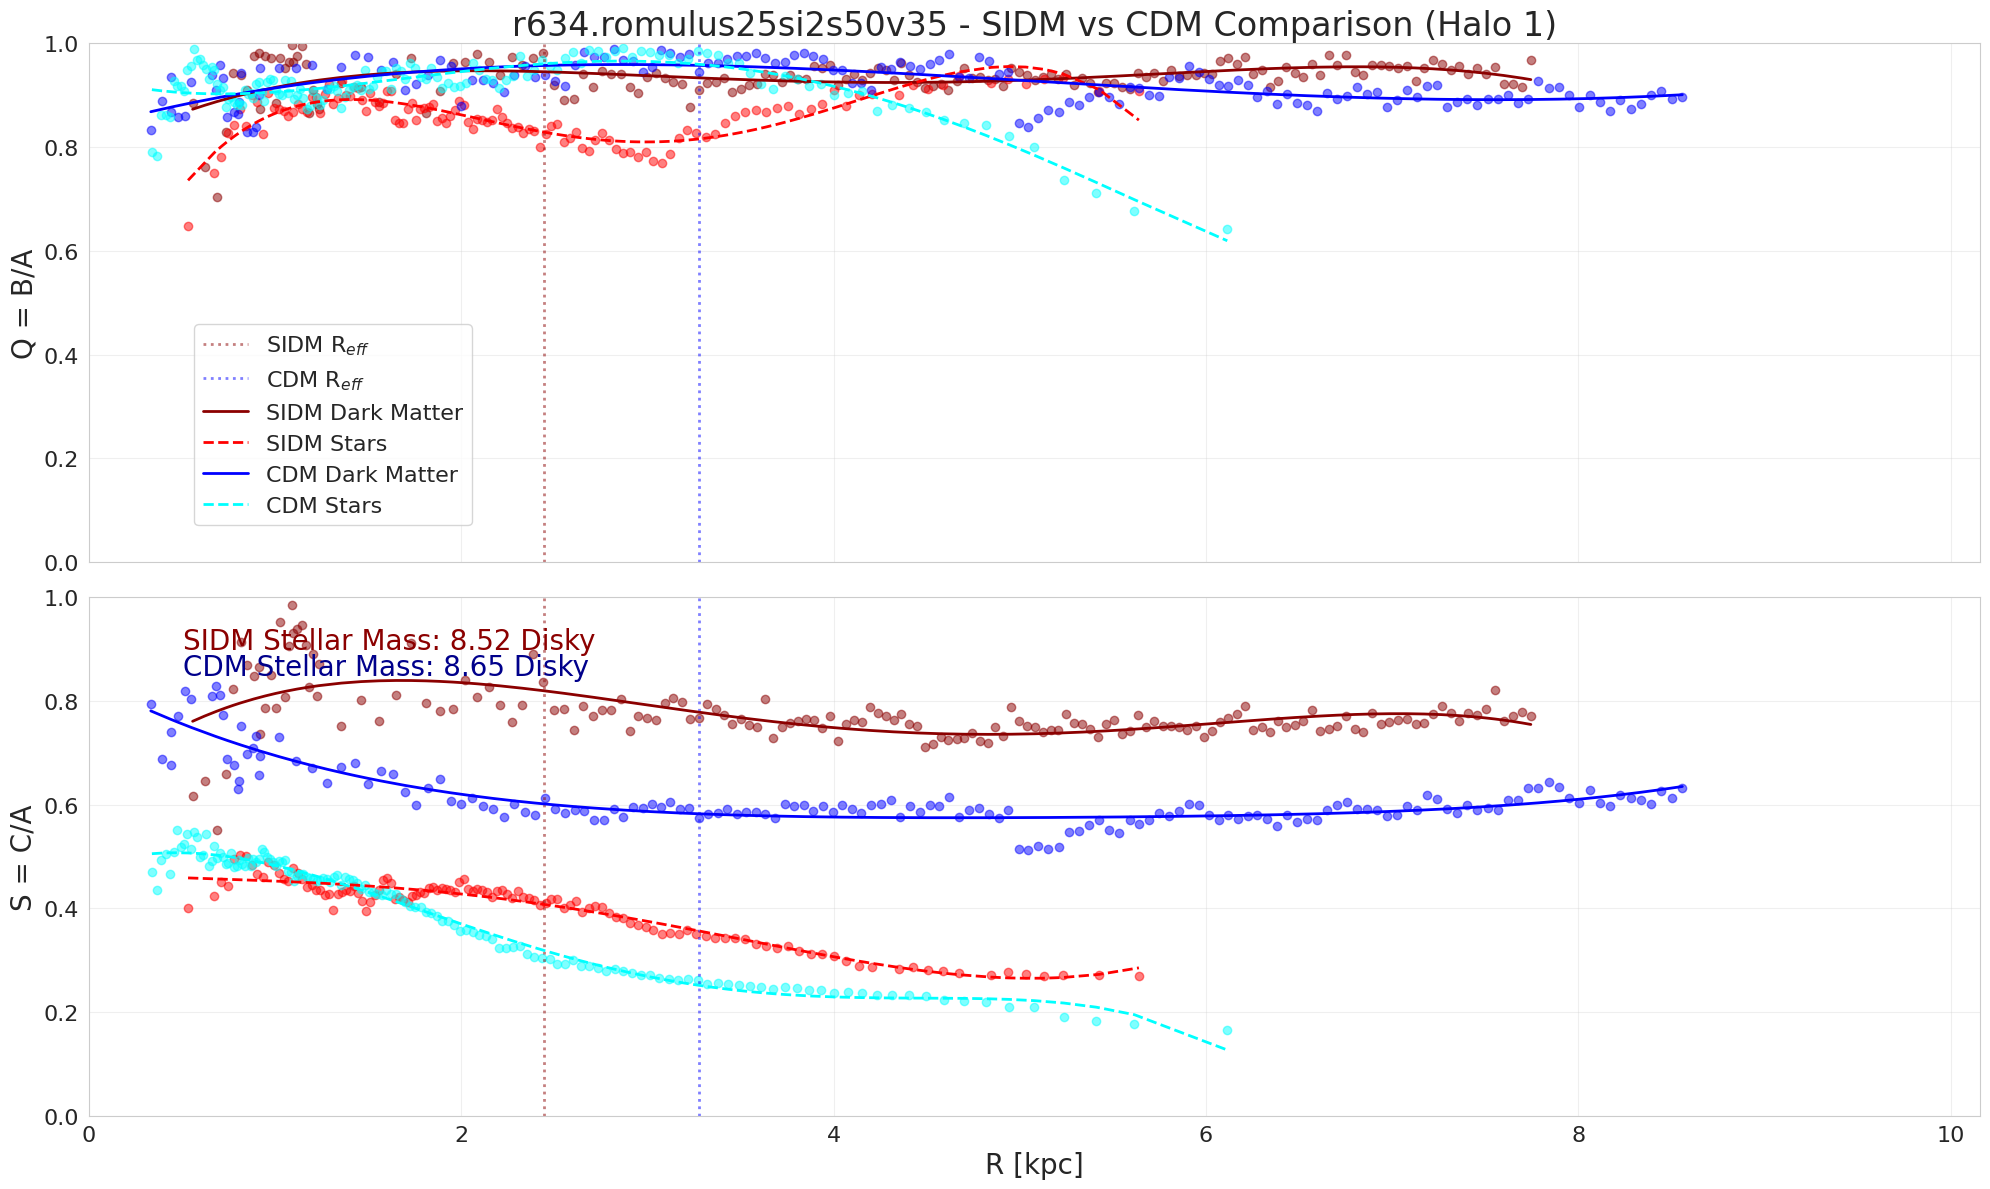

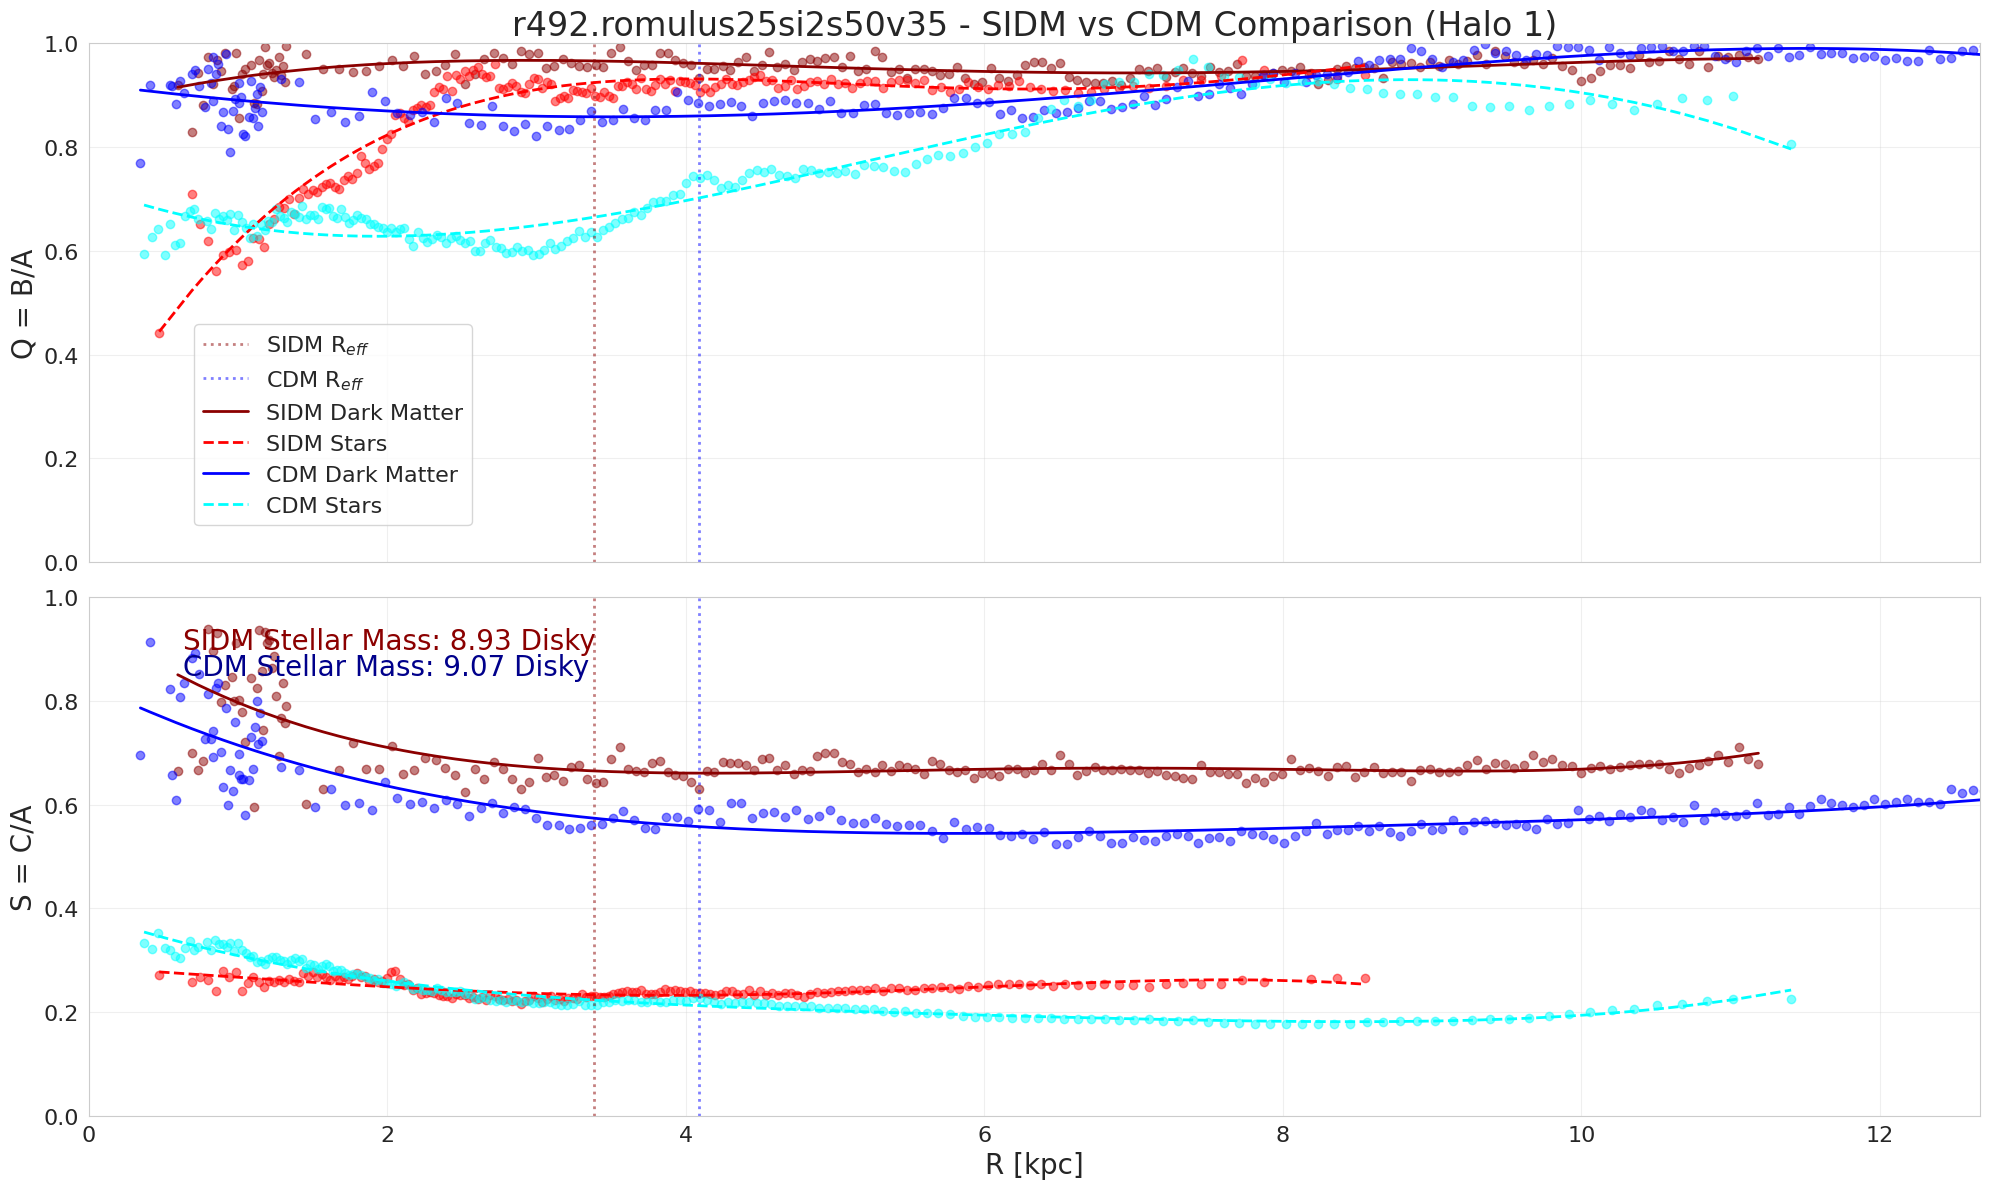

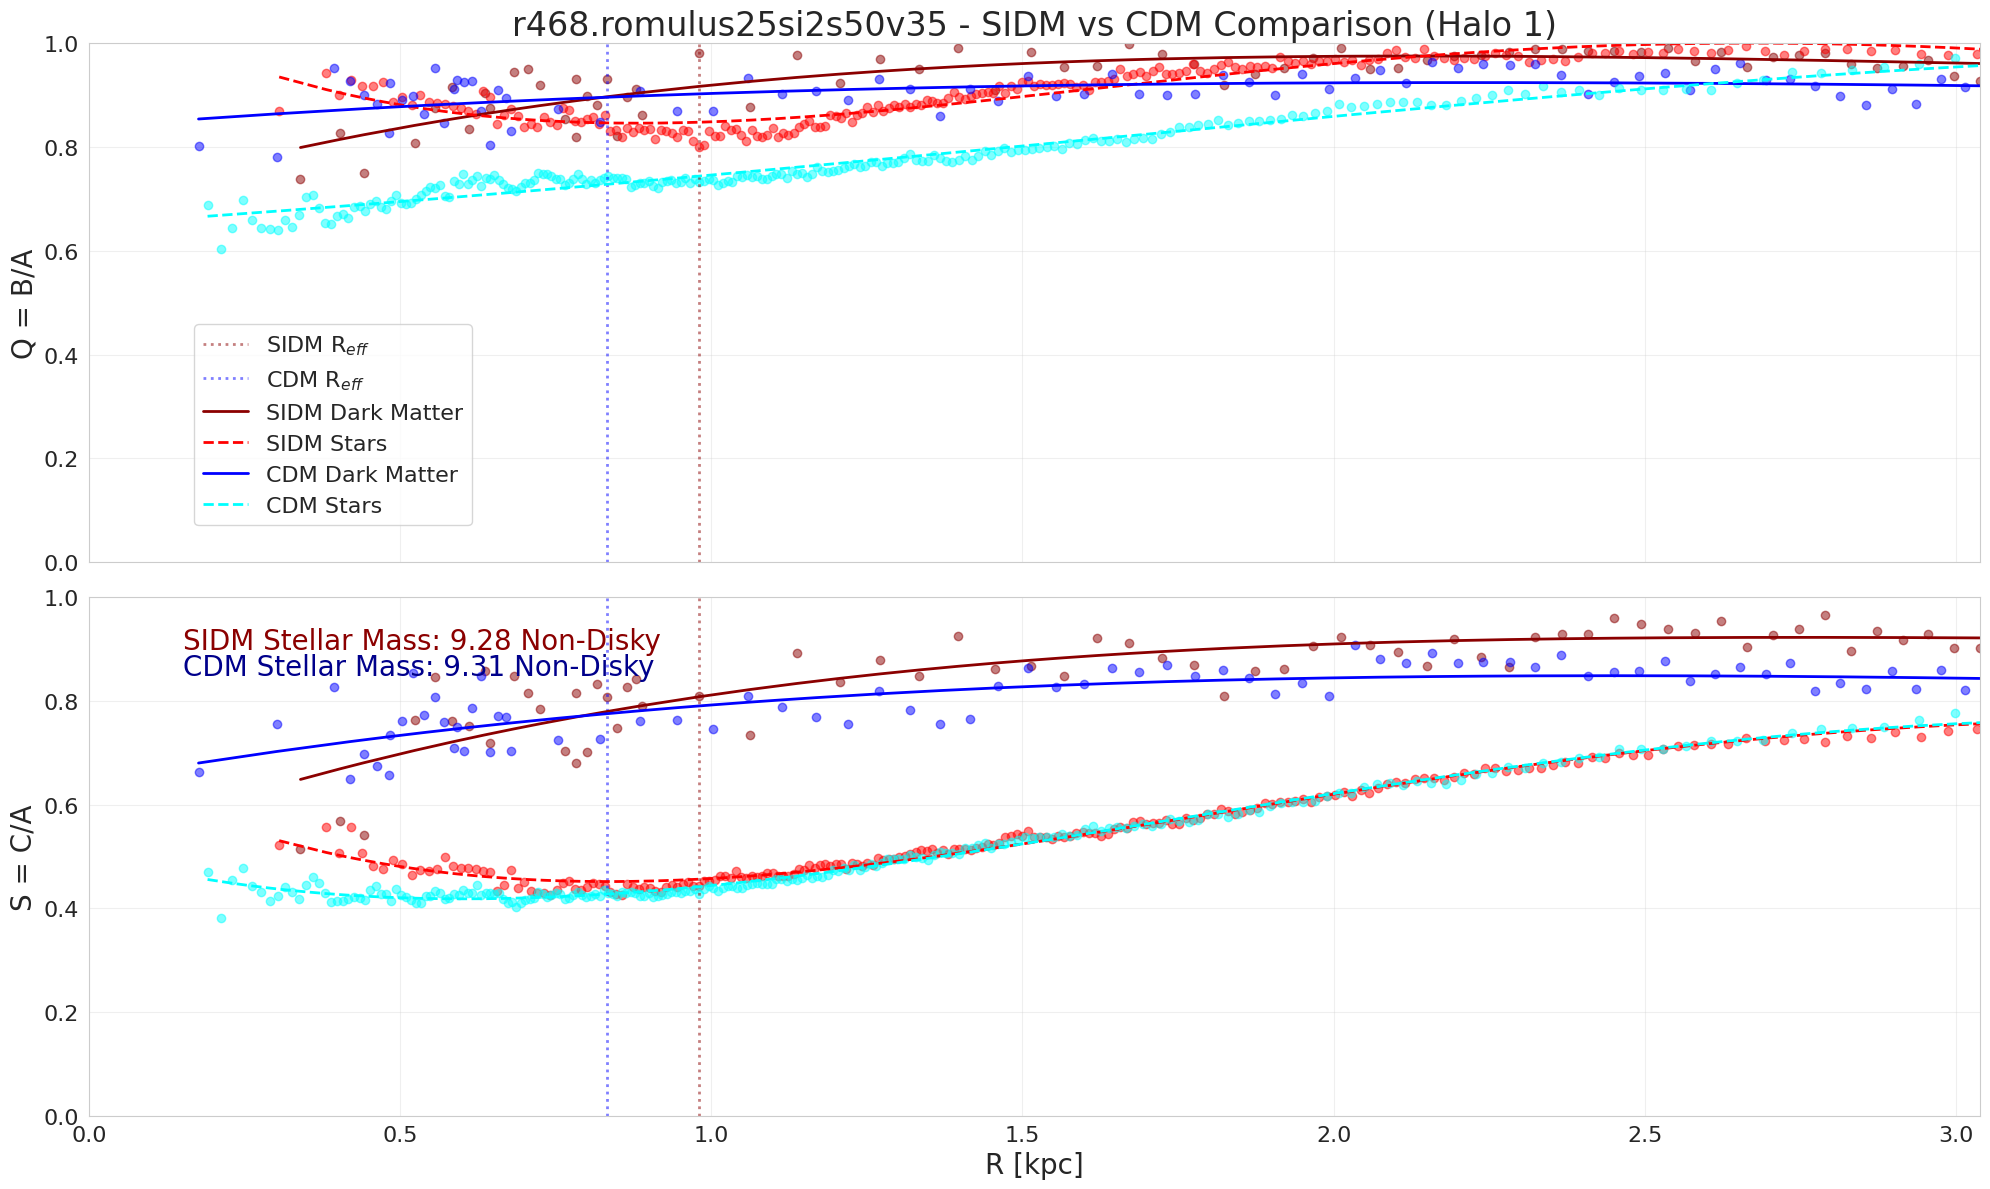

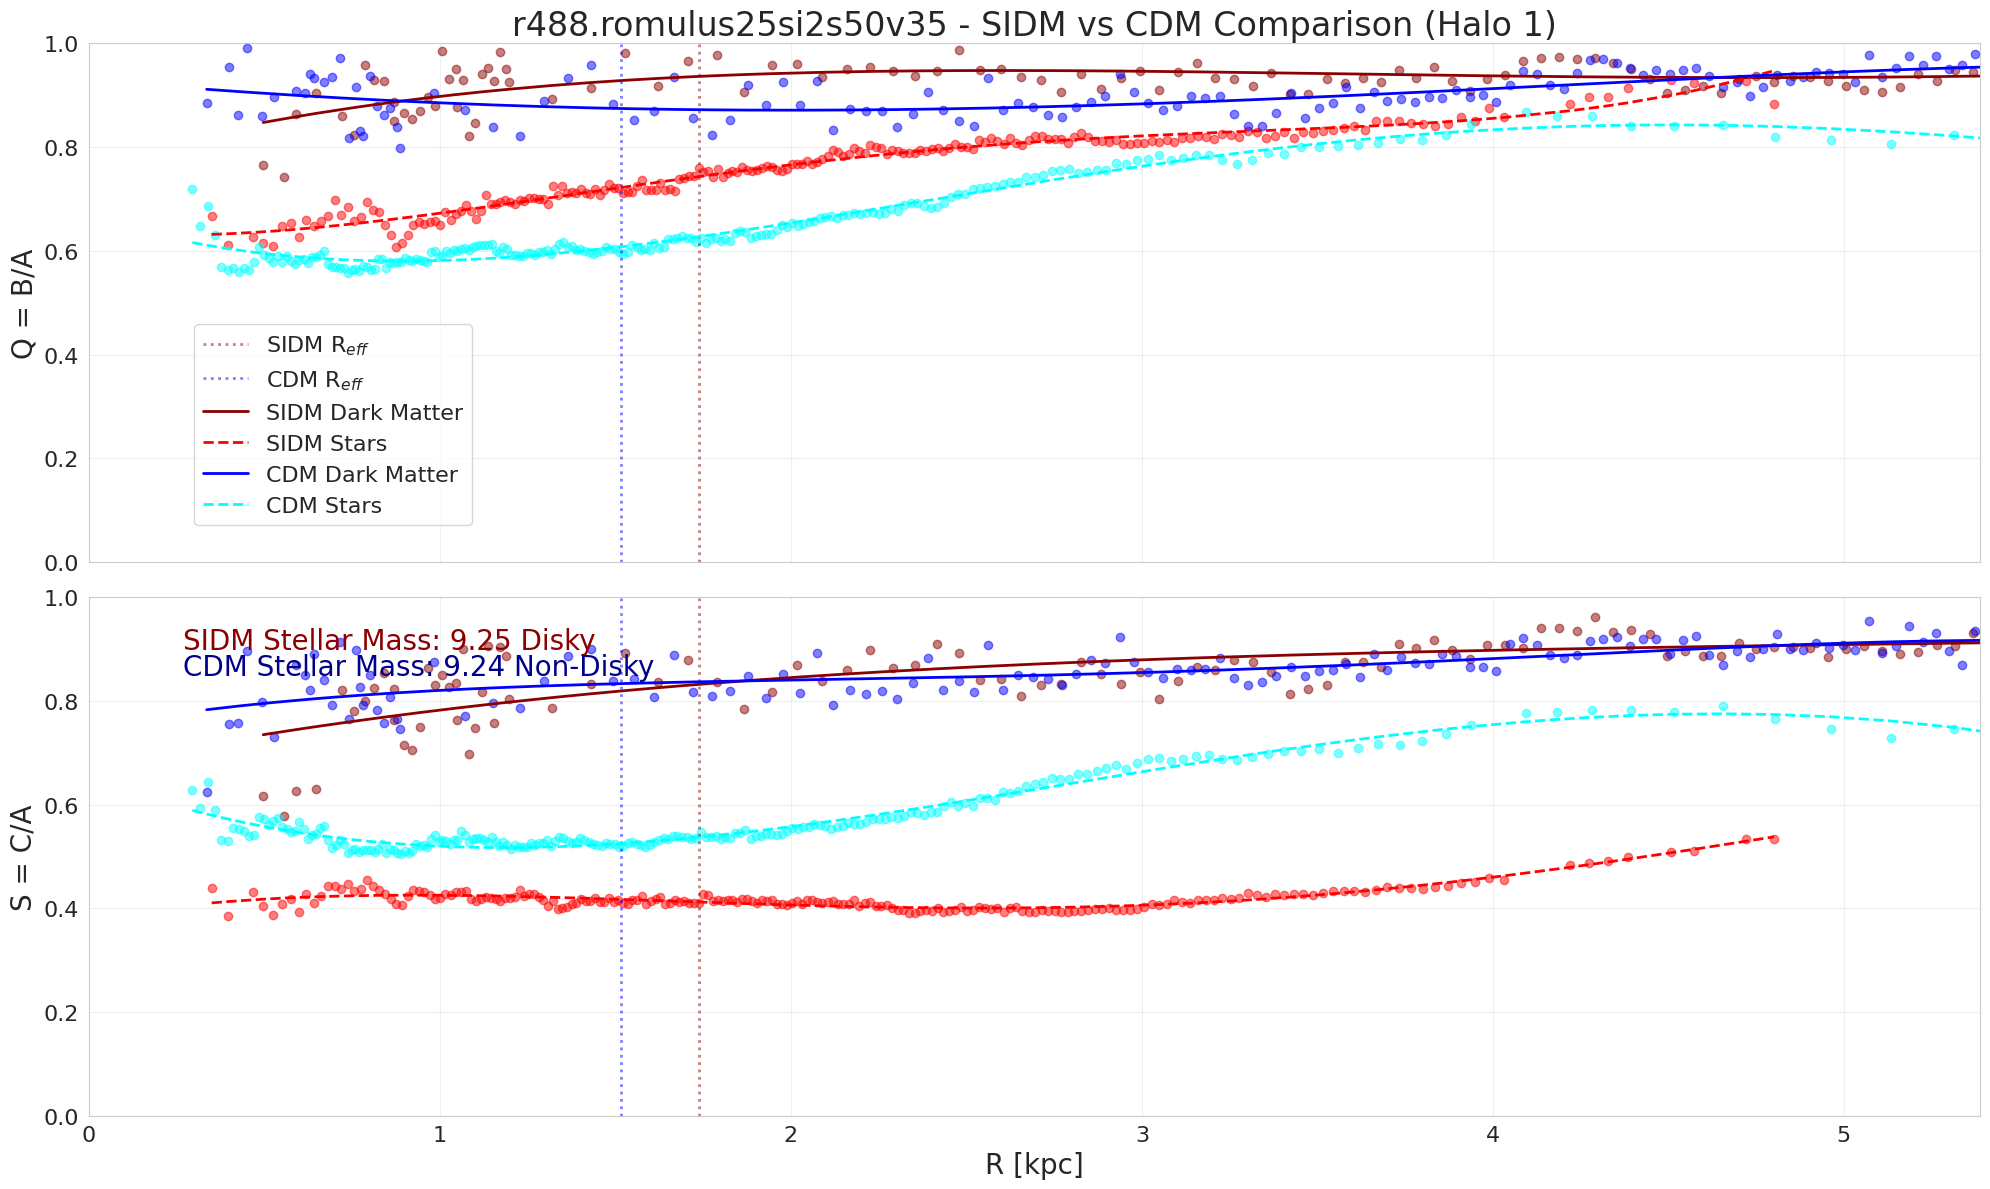

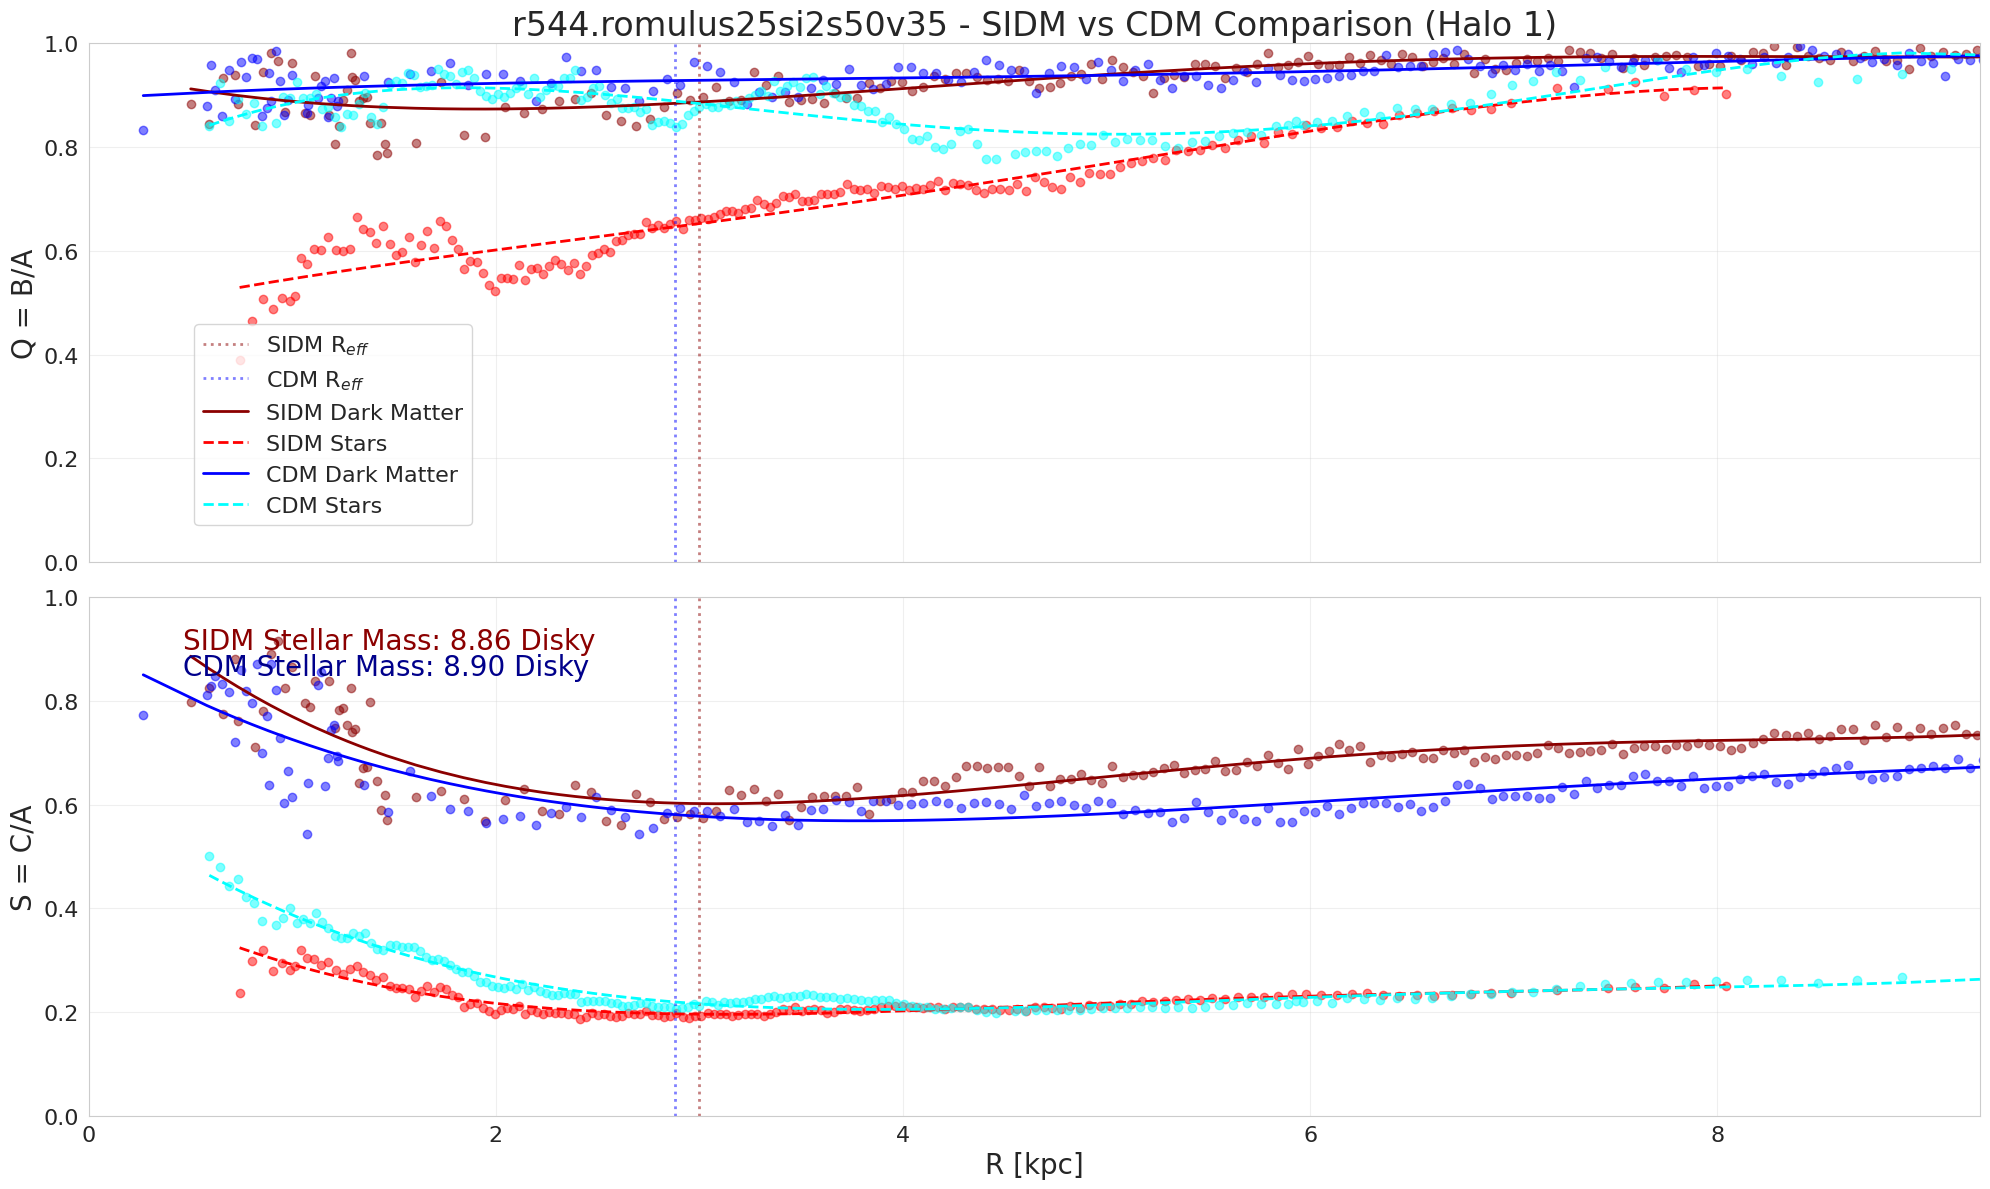

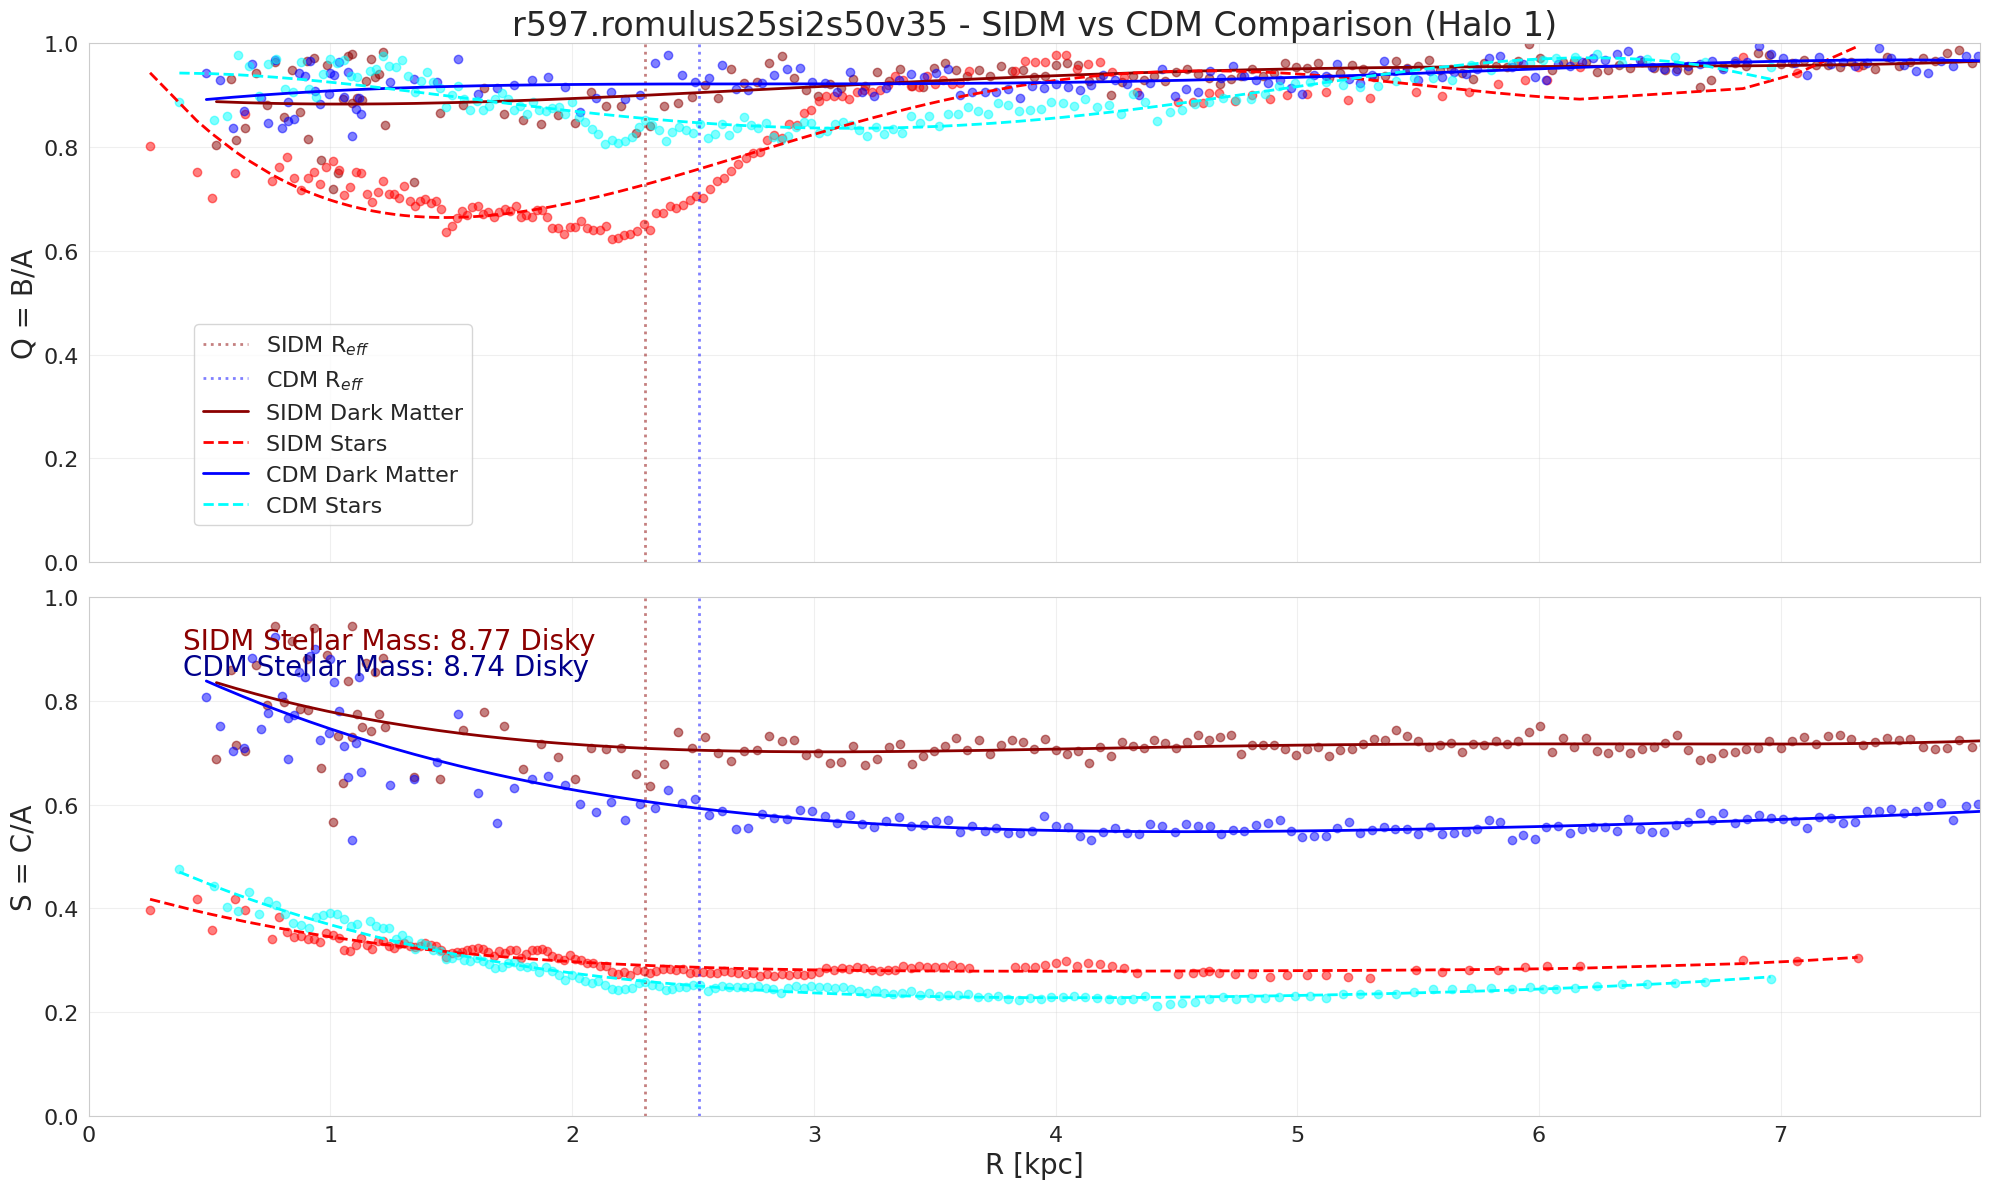

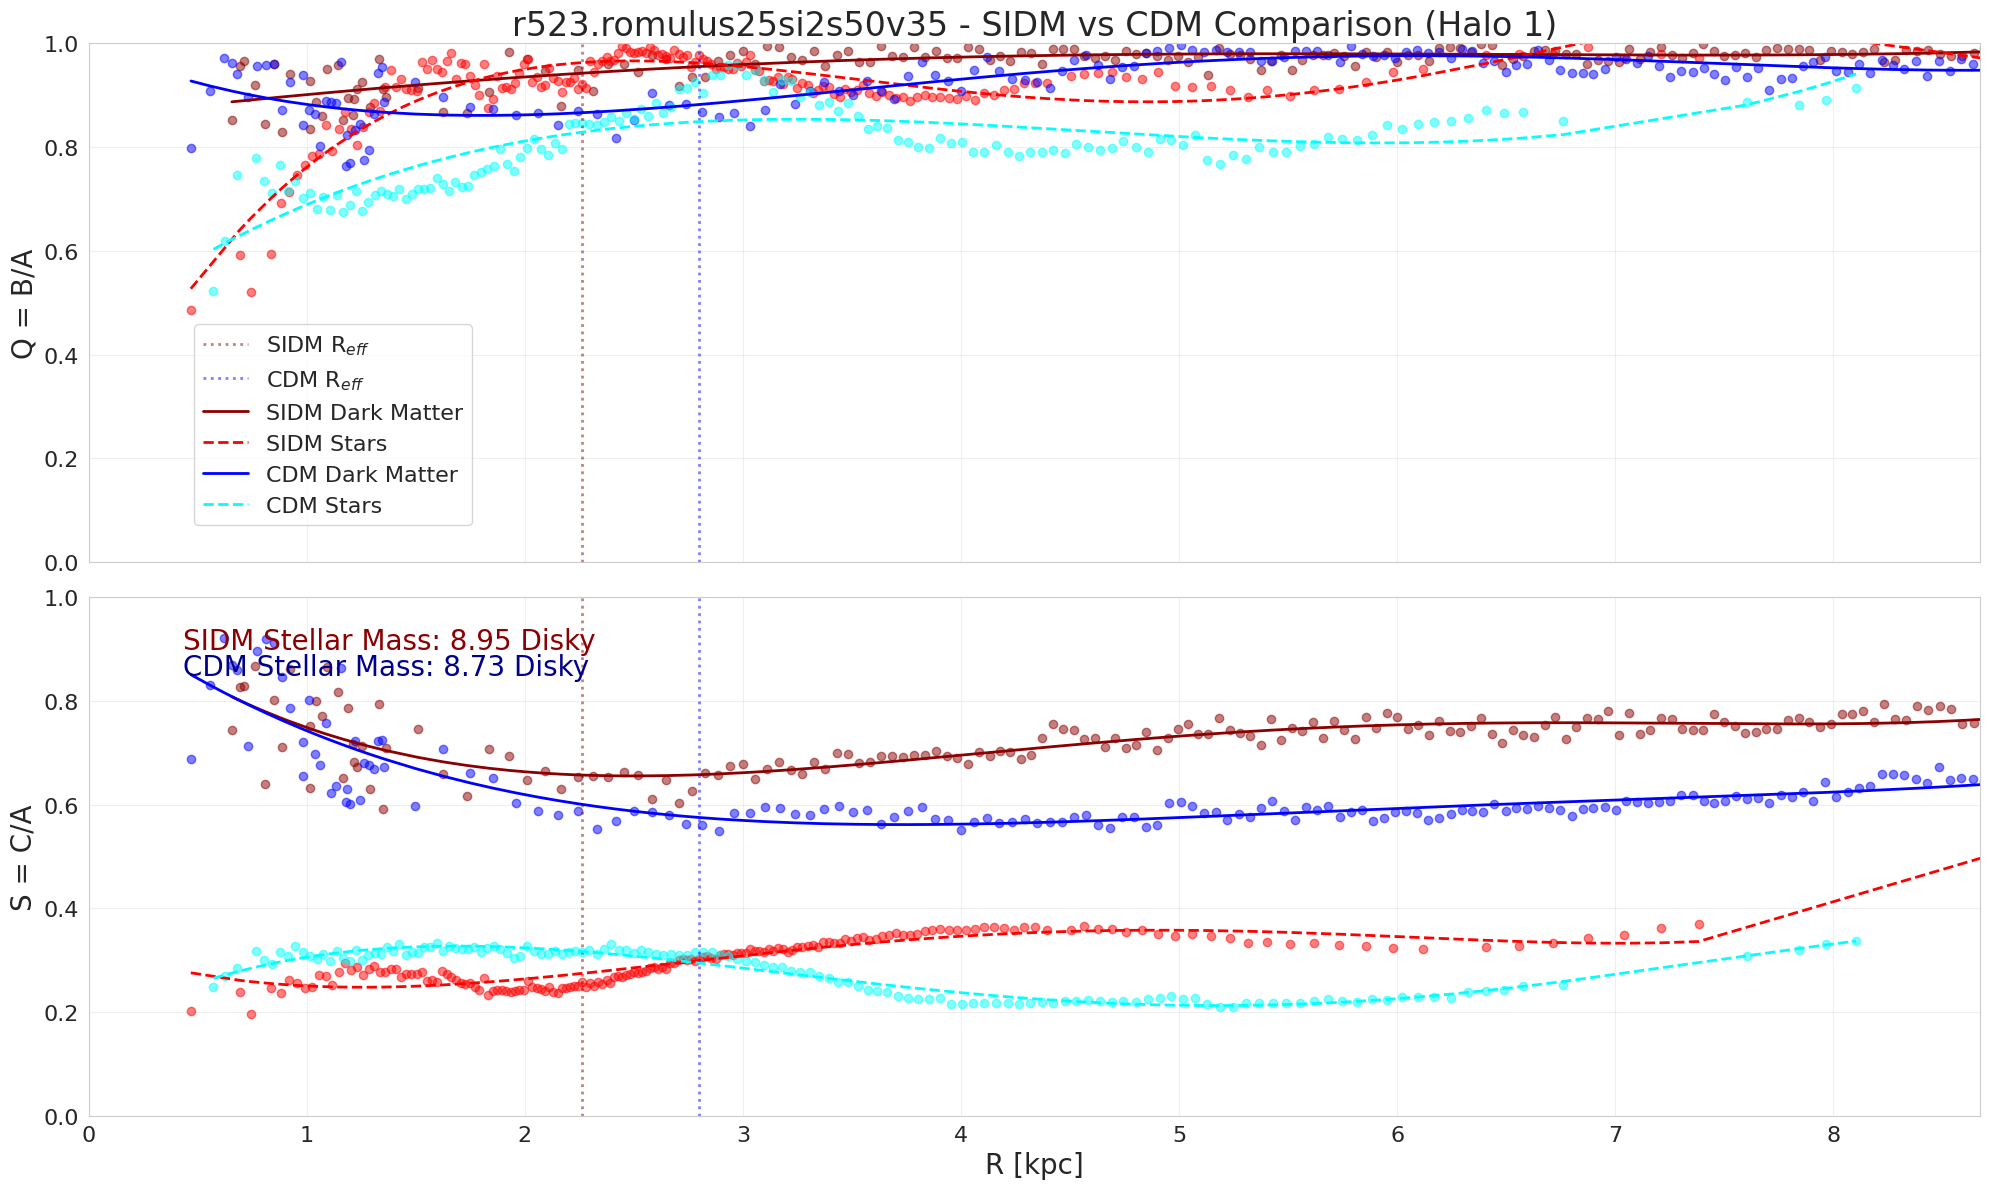

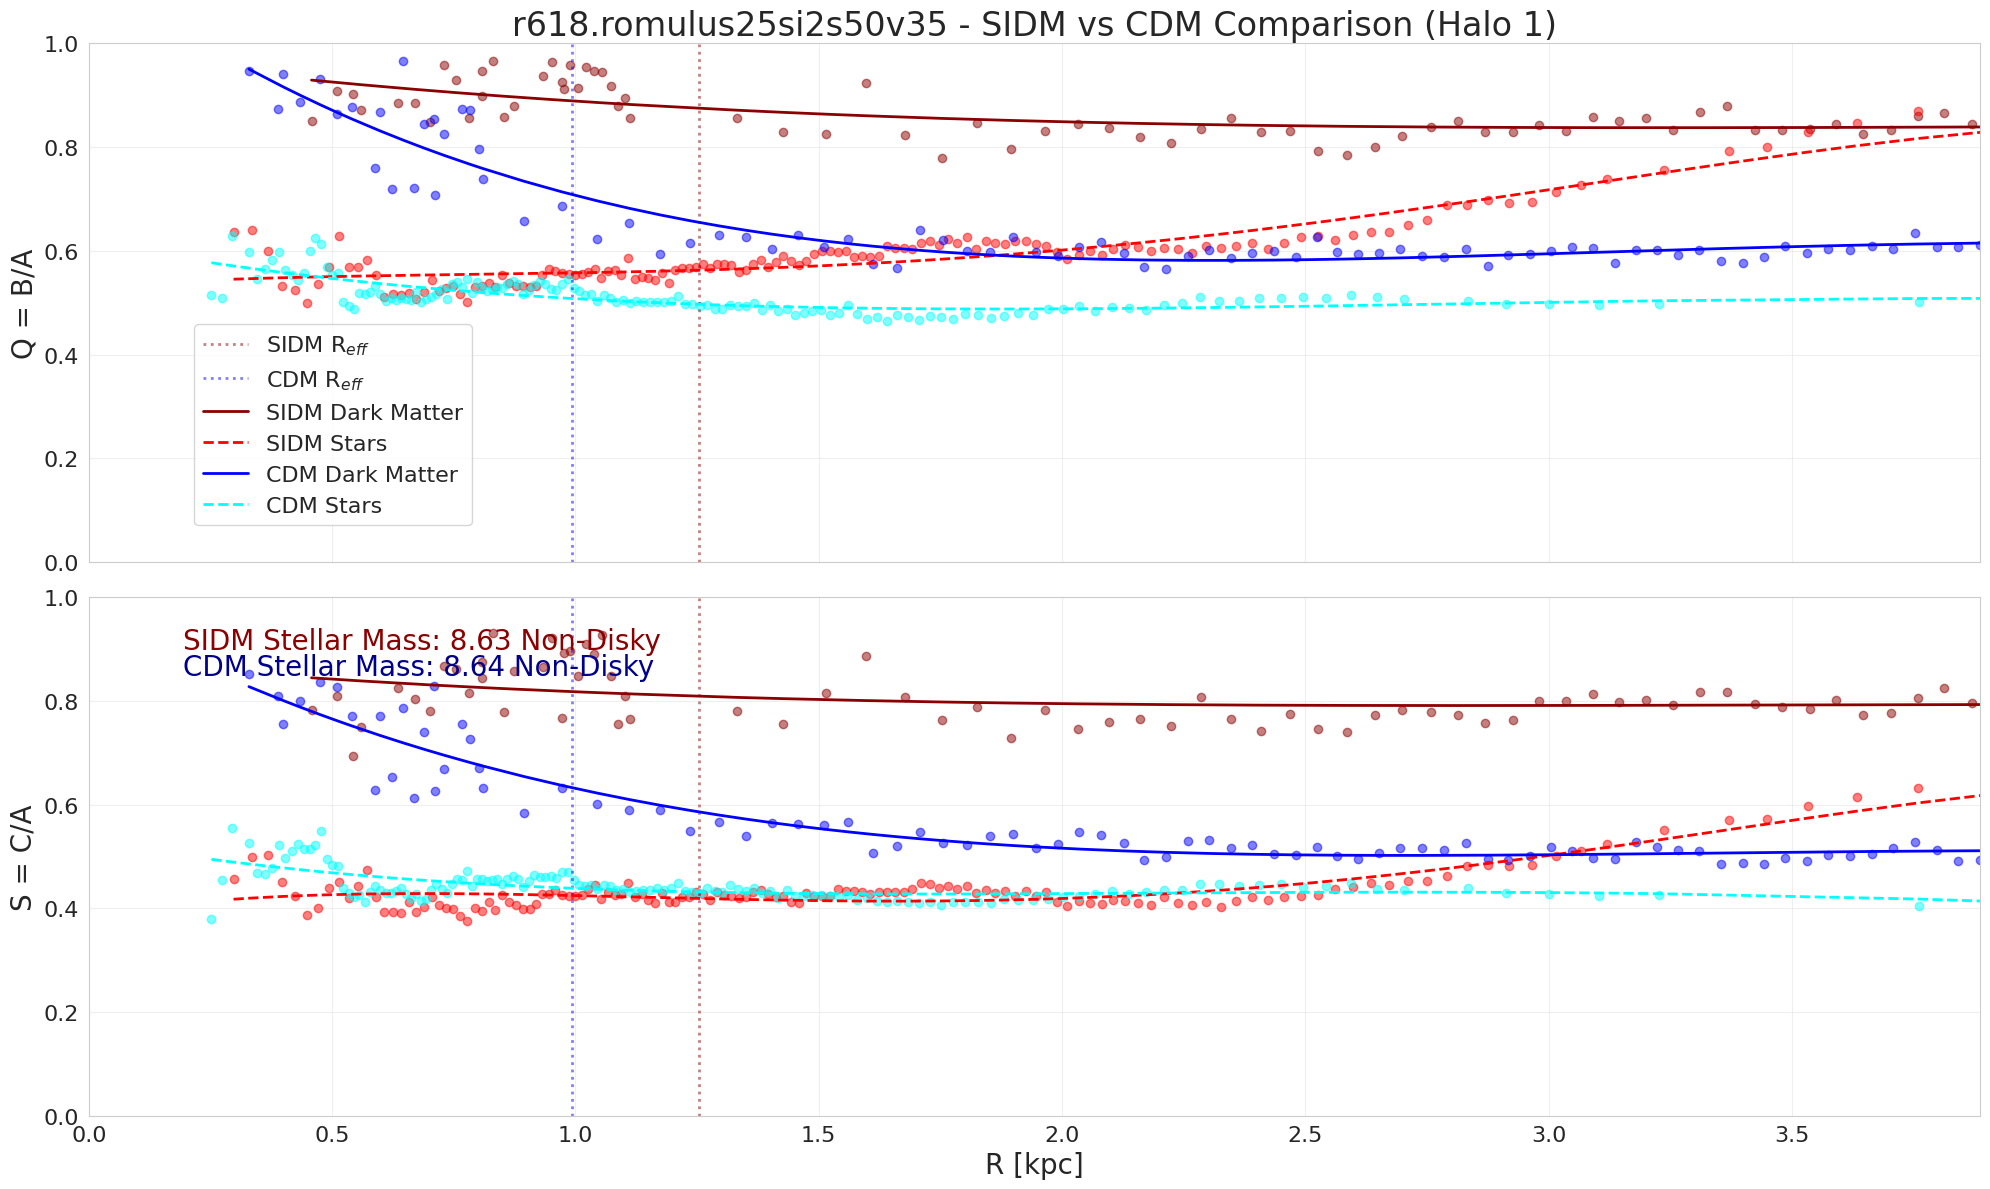

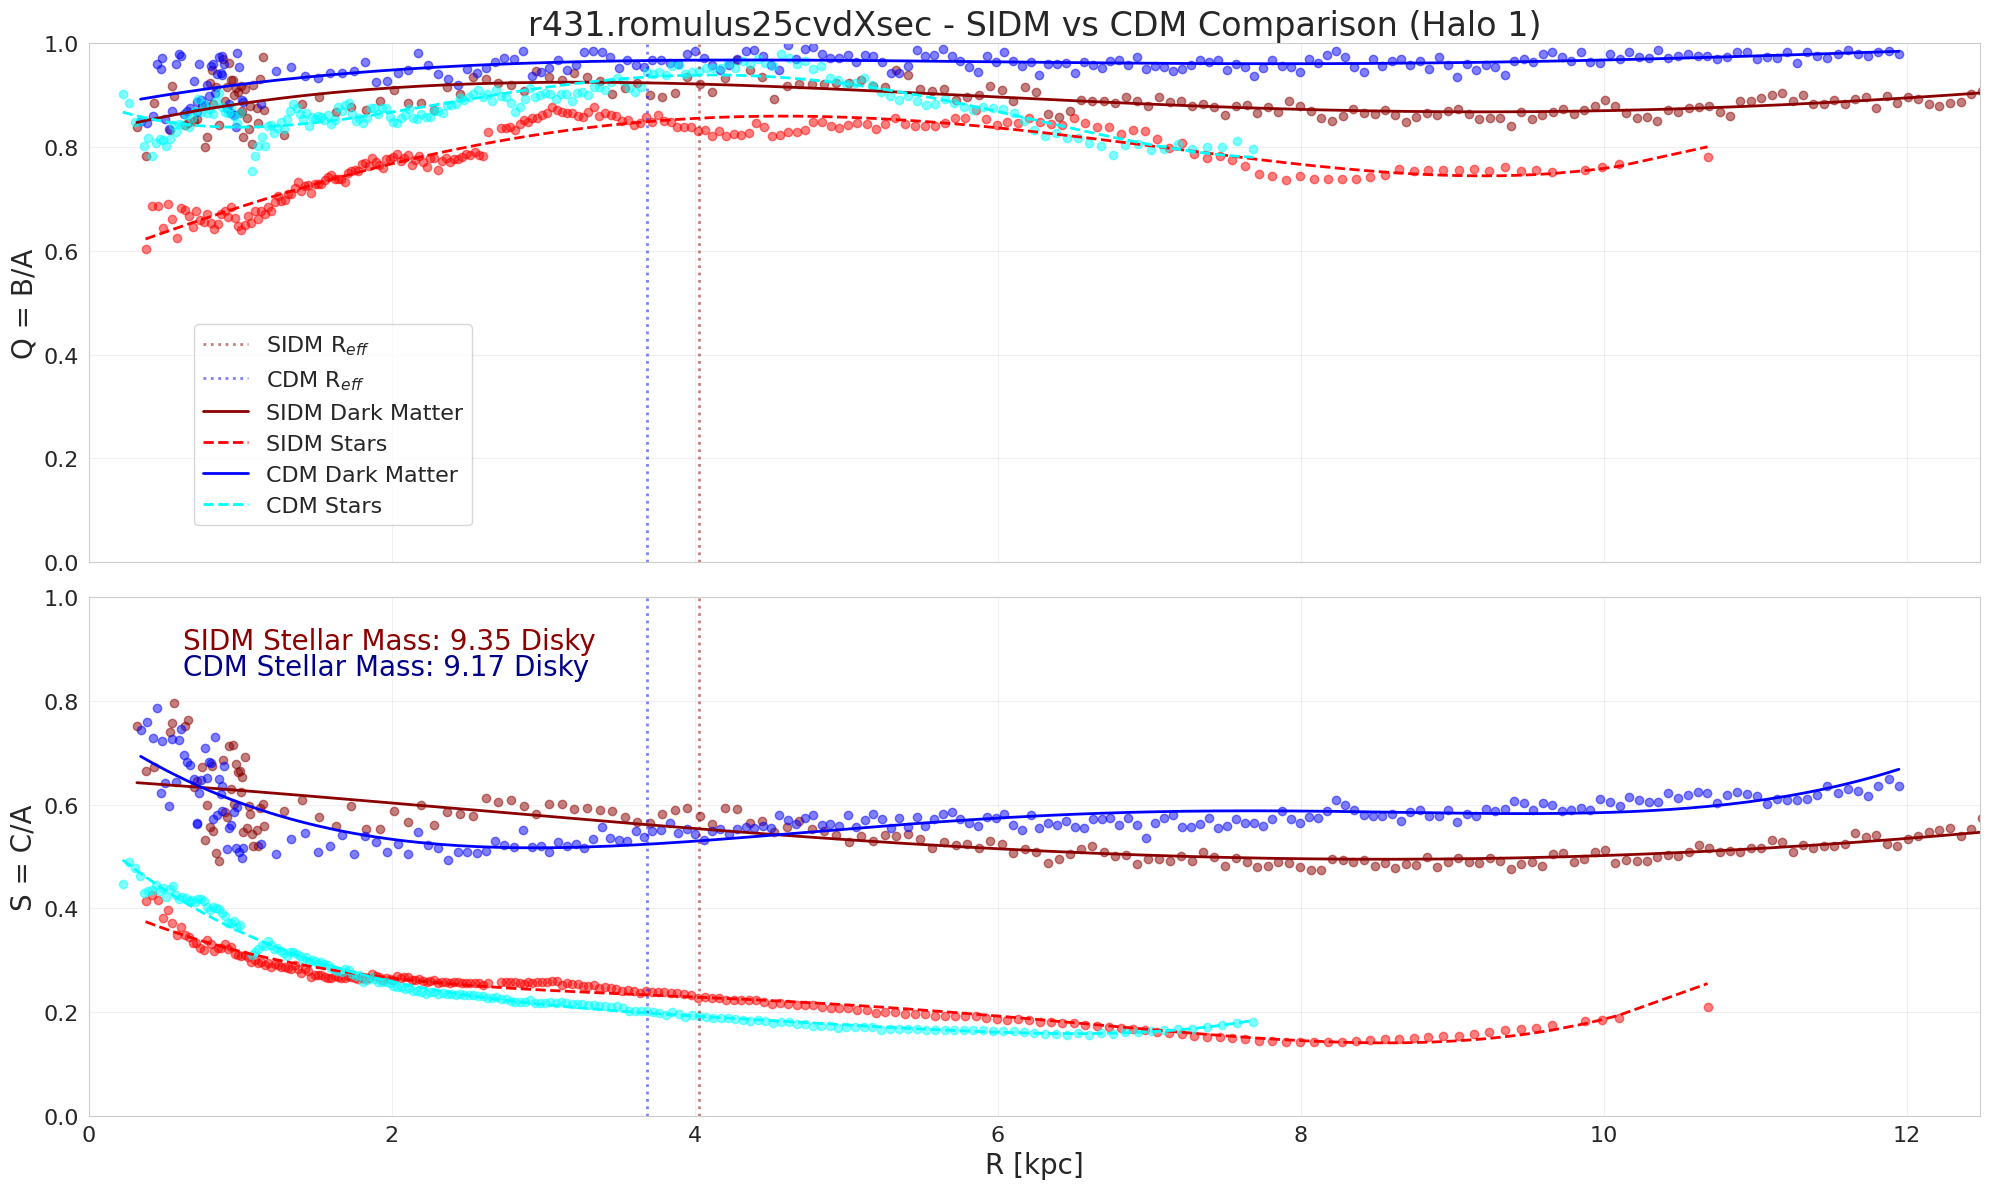

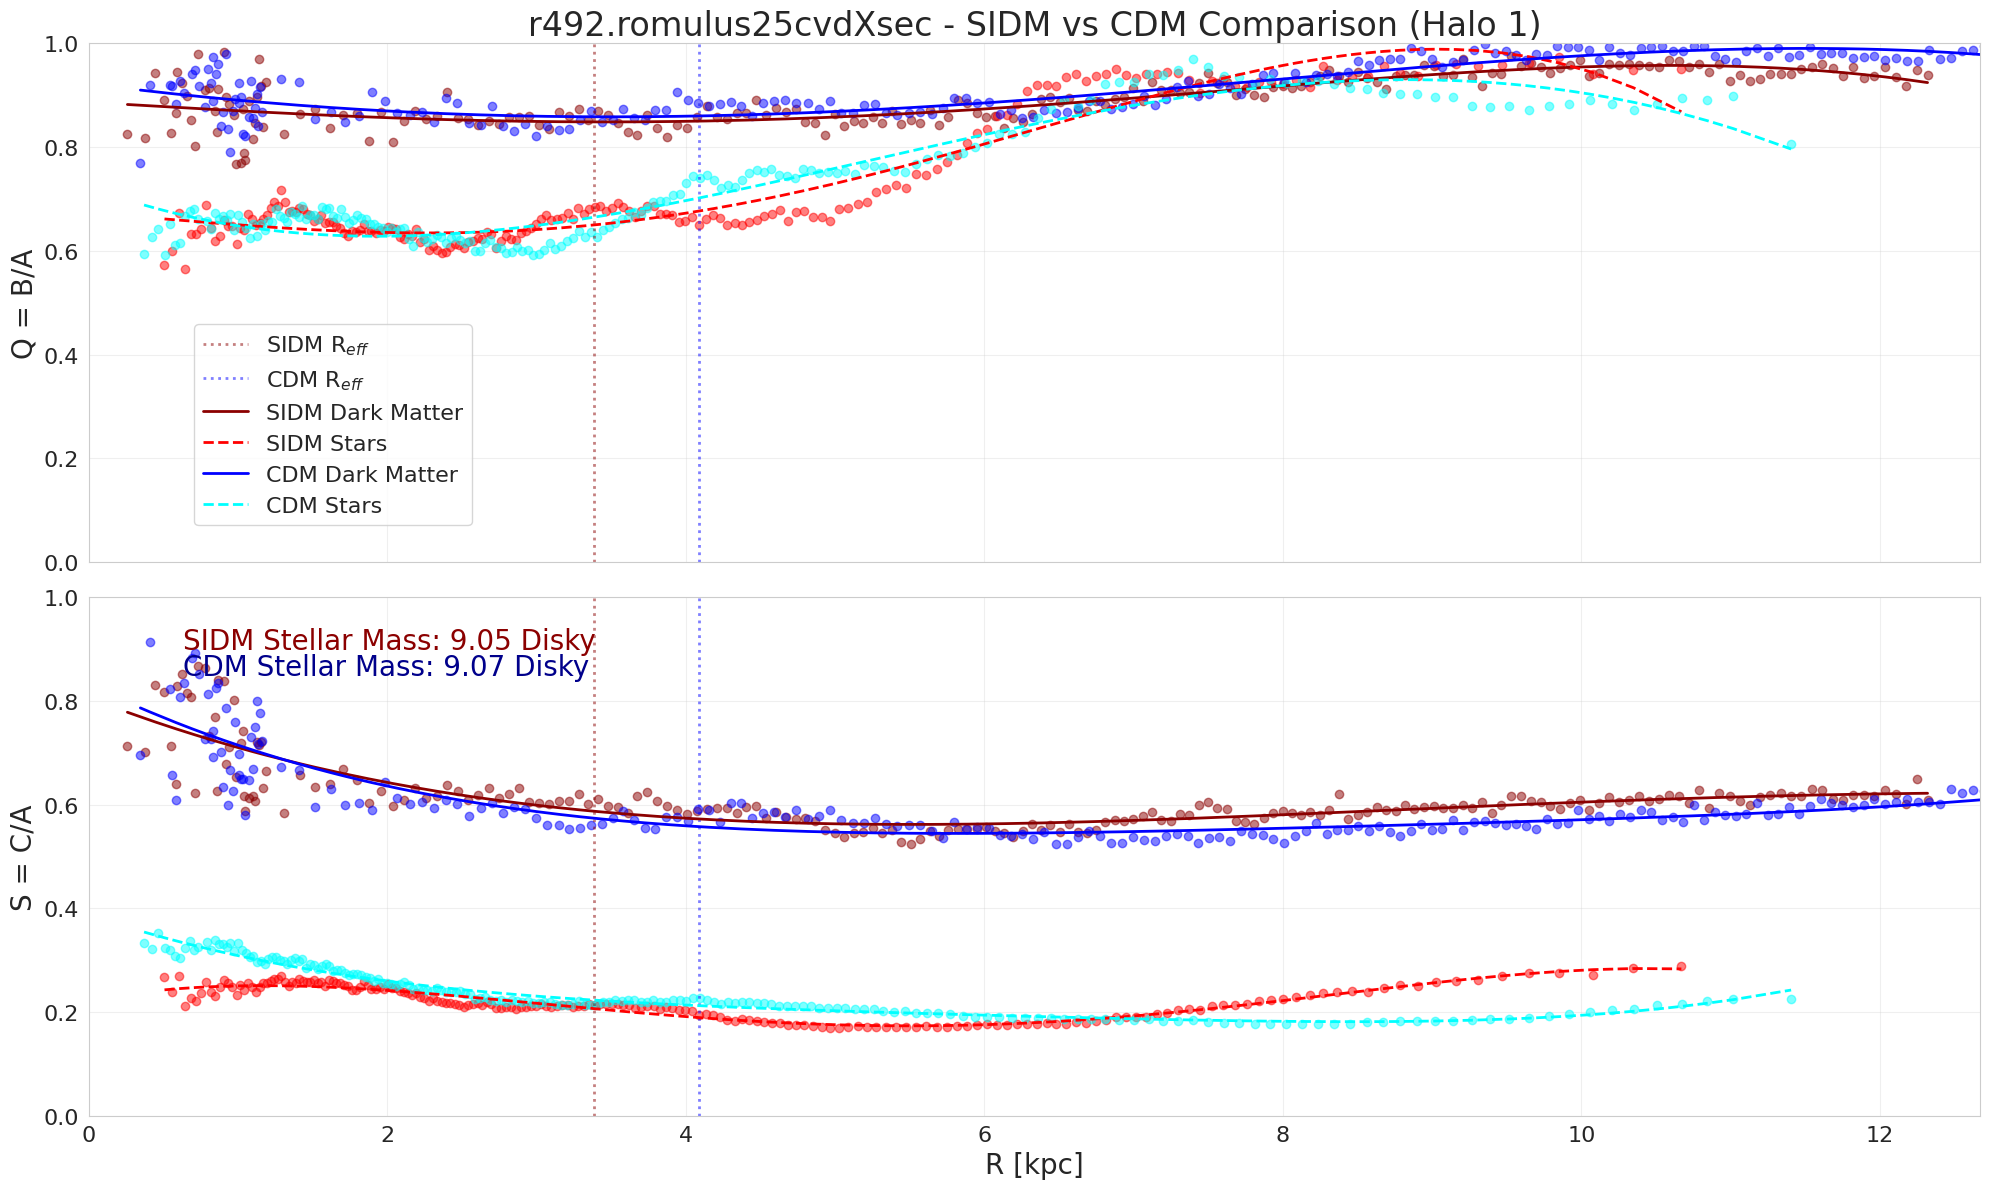

In [39]:

# Process each SIDM simulation and compare with corresponding CDM simulation
# Process each SIDM simulation and compare with corresponding CDM simulation

def smooth_and_filter_data(rbins, ba, ca):
    k = 4
    s_factor = 1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Print some diagnostic information
    # print(f"Total data points: {len(rbins)}")
    # print(f"Data points after NaN removal: {len(rbins_filtered)}")
    # print(f"NaN percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    n = len(rbins_filtered)
    # calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    # calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    # remove outliers
    d = 3

    mask = np.abs(ba_residuals) < d * ba_std

    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d * ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # remove any points that are isolated in space
    # calculate the difference between each point

    diff = np.diff(rbins_filtered, prepend=0)
    # print(diff)
    # mask isolated points
    mask = diff > 1
    # print(mask)
    # print(rbins_filtered[mask])
    # print(diff[mask])
    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)
    # Print some diagnostic information
    # print(f"Data points after outlier removal: {len(rbins_filtered)}")
    # print(f"Outlier percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    # def clip_function(func):
    #     def clipped(x):
    #         return np.clip(func(x), 0, 1)
    #
    #     return clipped
    #
    # # clip the function to 0,1
    # ba_s_c = clip_function(ba_s)
    # ca_s_c = clip_function(ca_s)

    return rbins_filtered, ba_filtered, ca_filtered, ba_s, ca_s

#use sims
use_sim = ['r488.romulus25si2s50v35','r442.romulus25si2s50v35','r556.romulus25si2s50v35','r597.romulus25si2s50v35','r568.romulus25si2s50v35']


for sim_name in SimInfos['MerianSIDM']:
    #split sim name into parts
    #eg r492.romulus25cvdXsec or r634.romulus25si2s50v35
    # if sim_name not in use_sim:
    #     continue
    sim = sim_name
    sim_parts = sim_name.split('.')
    sim = sim_parts[0]
    SI = sim_parts[1]
    print(sim_name)
    print(f'Processing {sim} for SIDM and CDM comparison.')

    try:
        # Load necessary data for SIDM
        sidm_masspath = f'../../Data/BasicData/MerianSIDM.Masses.pickle'
        cdm_masspath = f'../../Data/BasicData/MerianCDM.Masses.pickle'

        if os.path.exists(sidm_masspath) and os.path.exists(cdm_masspath):
            with open(sidm_masspath, 'rb') as f:
                sidm_mass_data = pickle.load(f)
            with open(cdm_masspath, 'rb') as f:
                cdm_mass_data = pickle.load(f)

        sidm_DMShapes = pickle.load(open(f'../../Data/{sim_name}.MerianSIDM.DMShapes.pickle', 'rb'))
        sidm_StarShapes = pickle.load(open(f'../../Data/{sim_name}.MerianSIDM.3DShapes.pickle', 'rb'))
        sidm_Profiles = pickle.load(open(f'../../Data/{sim_name}.MerianSIDM.Profiles.pickle', 'rb'))

        cdm_DMShapes = pickle.load(open(f'../../Data/{sim}.MerianCDM.DMShapes.pickle', 'rb'))
        cdm_StarShapes = pickle.load(open(f'../../Data/{sim}.MerianCDM.3DShapes.pickle', 'rb'))
        cdm_Profiles = pickle.load(open(f'../../Data/{sim}.MerianCDM.Profiles.pickle', 'rb'))

    except FileNotFoundError as e:
        print(f'Error loading pickle file: {e}')
        continue

    for hid in SimInfos['MerianSIDM'][sim_name]['goodhalos']:
        try:
            # SIDM data
            sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca = sidm_DMShapes[(hid)]['rbins'], sidm_DMShapes[(hid)]['ba'], sidm_DMShapes[(hid)]['ca']
            sidm_star_rbins, sidm_star_ba, sidm_star_ca = sidm_StarShapes[(hid)]['rbins'], sidm_StarShapes[(hid)]['ba'], sidm_StarShapes[(hid)]['ca']

            # CDM data
            cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca = cdm_DMShapes[(hid)]['rbins'], cdm_DMShapes[(hid)]['ba'], cdm_DMShapes[(hid)]['ca']
            cdm_star_rbins, cdm_star_ba, cdm_star_ca = cdm_StarShapes[(hid)]['rbins'], cdm_StarShapes[(hid)]['ba'], cdm_StarShapes[(hid)]['ca']
            #print(sidm_mass_data)
            sidm_sm = np.log10(sidm_mass_data[sim_name][str(hid)]['Mstar'])
            cdm_sm = np.log10(cdm_mass_data[sim][str(hid)]['Mstar'])

            if len(sidm_dm_rbins) > 0 and len(sidm_star_rbins) > 0 and len(cdm_dm_rbins) > 0 and len(cdm_star_rbins) > 0:
                sidm_reffs = []
                cdm_reffs = []
                for angle in sidm_Profiles[str(hid)]:
                    try:
                        sidm_reffs.append(sidm_Profiles[str(hid)][angle]['Reff'])
                        cdm_reffs.append(cdm_Profiles[str(hid)][angle]['Reff'])
                    except IndexError:
                        print(f'IndexError angle {angle} for halo {hid} in {sim}')
                    break



                # Create the plot
                #f, ax2 = plt.subplots(1, 1, figsize=FIGURE_SIZE, sharex=True)
                f, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True)
                max_r = max(3.1 * sidm_reffs[0], 3.1 * cdm_reffs[0])

                for ax in (ax1,ax2):
                    ax.set_ylim([0, 1])
                    ax.tick_params(which='both', labelsize=FONTSIZE_TICK)
                    # Plot Reff lines with corresponding colors
                    ax.axvline(sidm_reffs[0], c=COLOR_SIDM_DM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'SIDM {LABEL_REFF}')
                    ax.axvline(cdm_reffs[0], c=COLOR_CDM_DM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'CDM {LABEL_REFF}')
                    ax.grid(True, alpha=0.3)

                #ax = ax2
                #ax.set_xlim([0, max_r])


                                # Smooth and plot B/A using smooth_and_filter_data function
                sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca, sidm_dm_ba_smooth, sidm_dm_ca_smooth = smooth_and_filter_data(sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca)
                sidm_star_rbins, sidm_star_ba, sidm_star_ca, sidm_star_ba_smooth, sidm_star_ca_smooth = smooth_and_filter_data(sidm_star_rbins, sidm_star_ba, sidm_star_ca)
                cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca, cdm_dm_ba_smooth, cdm_dm_ca_smooth = smooth_and_filter_data(cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca)
                cdm_star_rbins, cdm_star_ba, cdm_star_ca, cdm_star_ba_smooth, cdm_star_ca_smooth = smooth_and_filter_data(cdm_star_rbins, cdm_star_ba, cdm_star_ca)

                #lot B/A
                ax1.scatter(sidm_dm_rbins, sidm_dm_ba, c=COLOR_SIDM_DM, alpha=ALPHA_RAW)
                ax1.scatter(sidm_star_rbins, sidm_star_ba, c=COLOR_SIDM_STAR, alpha=ALPHA_RAW)
                ax1.scatter(cdm_dm_rbins, cdm_dm_ba, c=COLOR_CDM_DM, alpha=ALPHA_RAW)
                ax1.scatter(cdm_star_rbins, cdm_star_ba, c=COLOR_CDM_STAR, alpha=ALPHA_RAW)


                ax1.plot(sidm_dm_rbins, sidm_dm_ba_smooth(sidm_dm_rbins), c=COLOR_SIDM_DM, label=LABEL_SIDM_DM, lw=LINEWIDTH, ls='-')
                ax1.plot(sidm_star_rbins, sidm_star_ba_smooth(sidm_star_rbins), c=COLOR_SIDM_STAR, label=LABEL_SIDM_STAR, lw=LINEWIDTH, ls='--')
                ax1.plot(cdm_dm_rbins, cdm_dm_ba_smooth(cdm_dm_rbins), c=COLOR_CDM_DM, label=LABEL_CDM_DM, lw=LINEWIDTH, ls='-')
                ax1.plot(cdm_star_rbins, cdm_star_ba_smooth(cdm_star_rbins), c=COLOR_CDM_STAR, label=LABEL_CDM_STAR, lw=LINEWIDTH, ls='--')

                ax1.set_title(f'{sim}.{SI} - SIDM vs CDM Comparison (Halo {hid})', fontsize=FONTSIZE_TITLE)
                ax1.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), prop={'size': FONTSIZE_LEGEND})
                ax1.set_ylabel(LABEL_BA, fontsize=FONTSIZE_LABEL)

                #Plot C/A

                ax2.plot(sidm_dm_rbins, sidm_dm_ca_smooth(sidm_dm_rbins), c=COLOR_SIDM_DM, label=LABEL_SIDM_DM, lw=LINEWIDTH, ls='-')
                ax2.plot(sidm_star_rbins, sidm_star_ca_smooth(sidm_star_rbins), c=COLOR_SIDM_STAR, label=LABEL_SIDM_STAR, lw=LINEWIDTH, ls='--')
                ax2.plot(cdm_dm_rbins, cdm_dm_ca_smooth(cdm_dm_rbins), c=COLOR_CDM_DM, label=LABEL_CDM_DM, lw=LINEWIDTH, ls='-')
                ax2.plot(cdm_star_rbins, cdm_star_ca_smooth(cdm_star_rbins), c=COLOR_CDM_STAR, label=LABEL_CDM_STAR, lw=LINEWIDTH, ls='--')

                ax2.set_ylabel(LABEL_CA, fontsize=FONTSIZE_LABEL)
                ax2.set_xlabel(LABEL_R_KPC, fontsize=FONTSIZE_LABEL)

                #ax2.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), prop={'size': FONTSIZE_LEGEND})

                #scatter plot of raw data

                ax2.scatter(sidm_dm_rbins, sidm_dm_ca, c=COLOR_SIDM_DM, alpha=ALPHA_RAW)
                ax2.scatter(sidm_star_rbins, sidm_star_ca, c=COLOR_SIDM_STAR, alpha=ALPHA_RAW)
                ax2.scatter(cdm_dm_rbins, cdm_dm_ca, c=COLOR_CDM_DM, alpha=ALPHA_RAW)
                ax2.scatter(cdm_star_rbins, cdm_star_ca, c=COLOR_CDM_STAR, alpha=ALPHA_RAW)


                #get whether or not CDM version is considered disky from  f'galaxy_classifications_{feedback}.pickle'
                #load galaxy classifications
                galaxy_classificationsCDM = pickle.load(open(f'galaxy_classifications_MerianCDM.pickle','rb'))
                galaxy_classificationsSIDM = pickle.load(open(f'galaxy_classifications_MerianSIDM.pickle','rb'))
                
                #get disky classification of current CDM halo
                CDMdisky = galaxy_classificationsCDM[sim][hid]
                #get disky classification of current SIDM halo
                SIDMdisky = galaxy_classificationsSIDM[sim_name][hid]
                #if 'd' label as disky, otherwise label as non-disky\

                #print(galaxy_classificationsSIDM)
                #print(sim,SI)
                if CDMdisky == 'd':
                    CDMdisky = 'Disky'
                else:
                    CDMdisky = 'Non-Disky'
                if SIDMdisky == 'd':
                    SIDMdisky = 'Disky'
                else:
                    SIDMdisky = 'Non-Disky'


                ax.set_xlim([0, max_r])

                #add stellar mass of sidm and cdm as text labeling the plot
                ax2.text(0.05, 0.9, f'SIDM Stellar Mass: {sidm_sm:.2f} {SIDMdisky}', transform=ax2.transAxes, fontsize=FONTSIZE_LABEL, color='darkred')
                ax2.text(0.05, 0.85, f'CDM Stellar Mass: {cdm_sm:.2f} {CDMdisky}', transform=ax2.transAxes, fontsize=FONTSIZE_LABEL, color='darkblue')

                #ax2.set_title(f'{sim}{SI} - Halo {hid}', fontsize=FONTSIZE_TITLE)

                # Create new folder for saving figures
                os.makedirs('../../Figures/3DShapes/SIDM_CDM_Comparison/', exist_ok=True)

                plt.tight_layout()
                plt.savefig(f'../../Figures/3DShapes/SIDM_CDM_Comparison/Shapes.{sim}{SI}.SIDM_vs_CDM.{hid}.png')
                #plt.close()

        except Exception as e:
            print(f"An error occurred during processing halo {hid} in {sim}: {e}")
            print(traceback.format_exc())


print("Processing complete.")

Feedback type: MerianSIDMad
r431
r442
r468
r488
r492
Feedback type: MerianCDMad
r431
r468
r492
r502
r515
r523
r544
r556
r568
r569
r571
r613
r614
r615
r618
r634
r431
Processing r431 for SIDM and CDM comparison.
r442
Processing r442 for SIDM and CDM comparison.
Error loading pickle file: [Errno 2] No such file or directory: '../../Data/r442.MerianCDMad.DMShapes.pickle'
r468
Processing r468 for SIDM and CDM comparison.
r488
Processing r488 for SIDM and CDM comparison.
Error loading pickle file: [Errno 2] No such file or directory: '../../Data/r488.MerianCDMad.DMShapes.pickle'
r492
Processing r492 for SIDM and CDM comparison.
Processing complete.


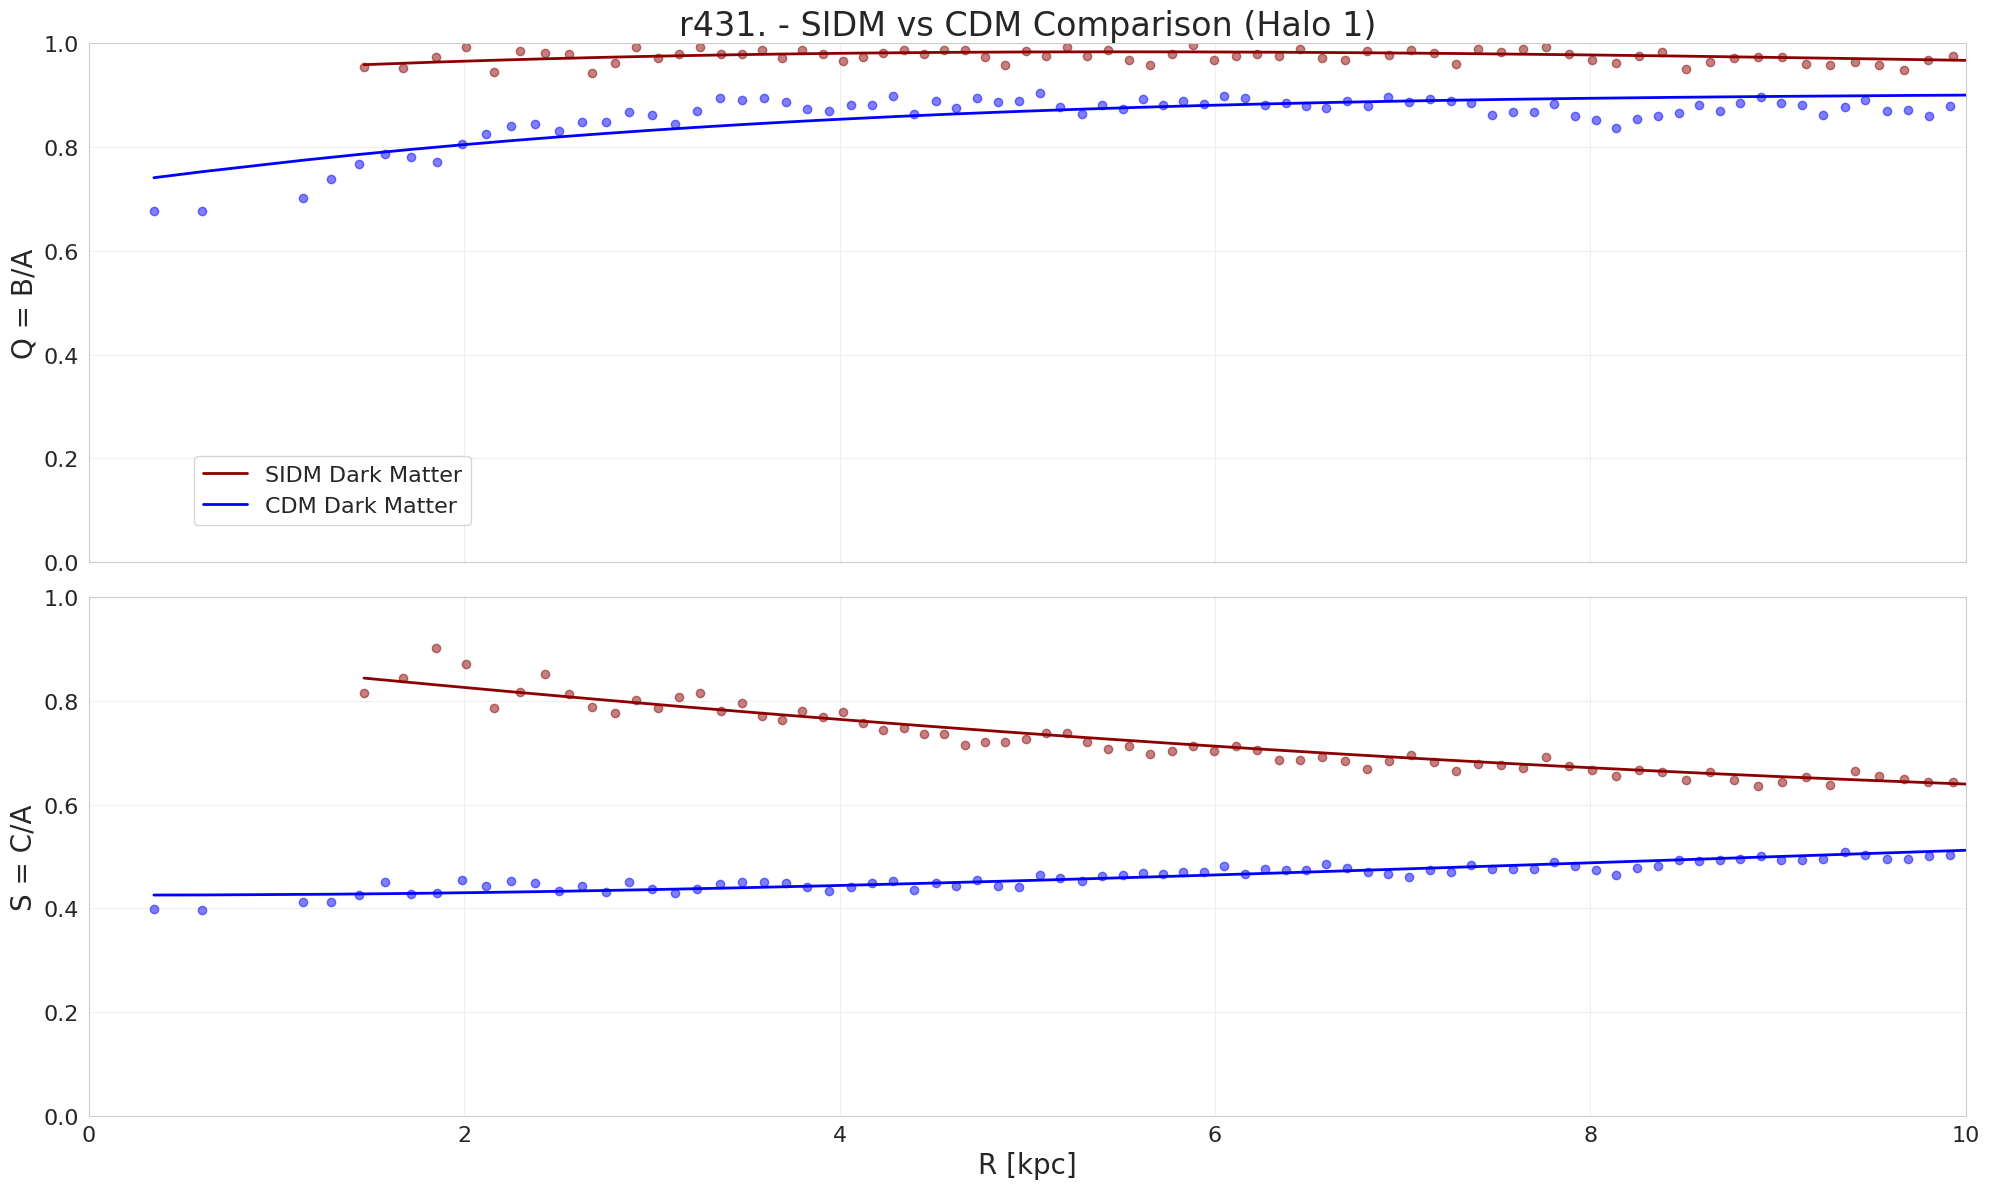

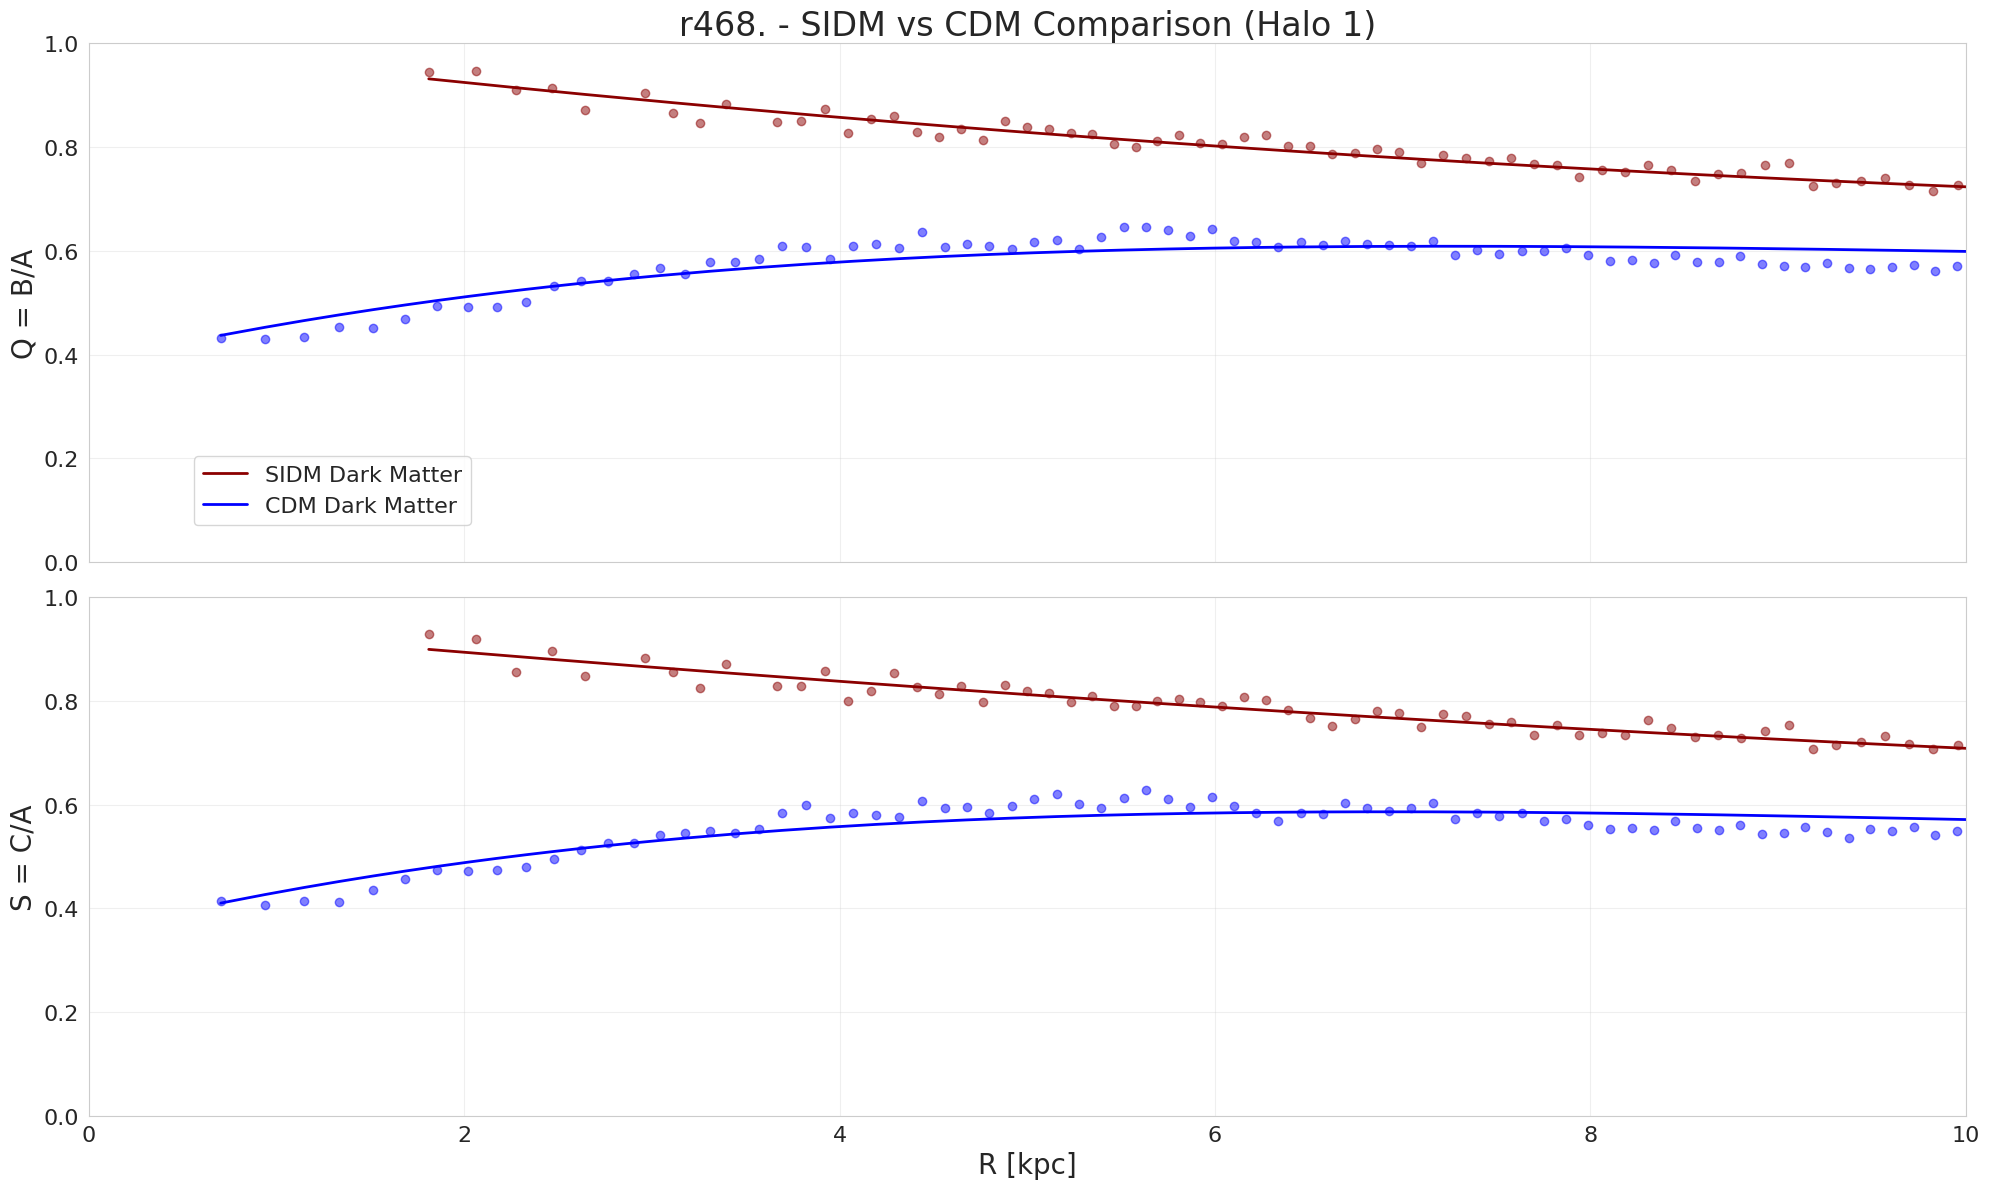

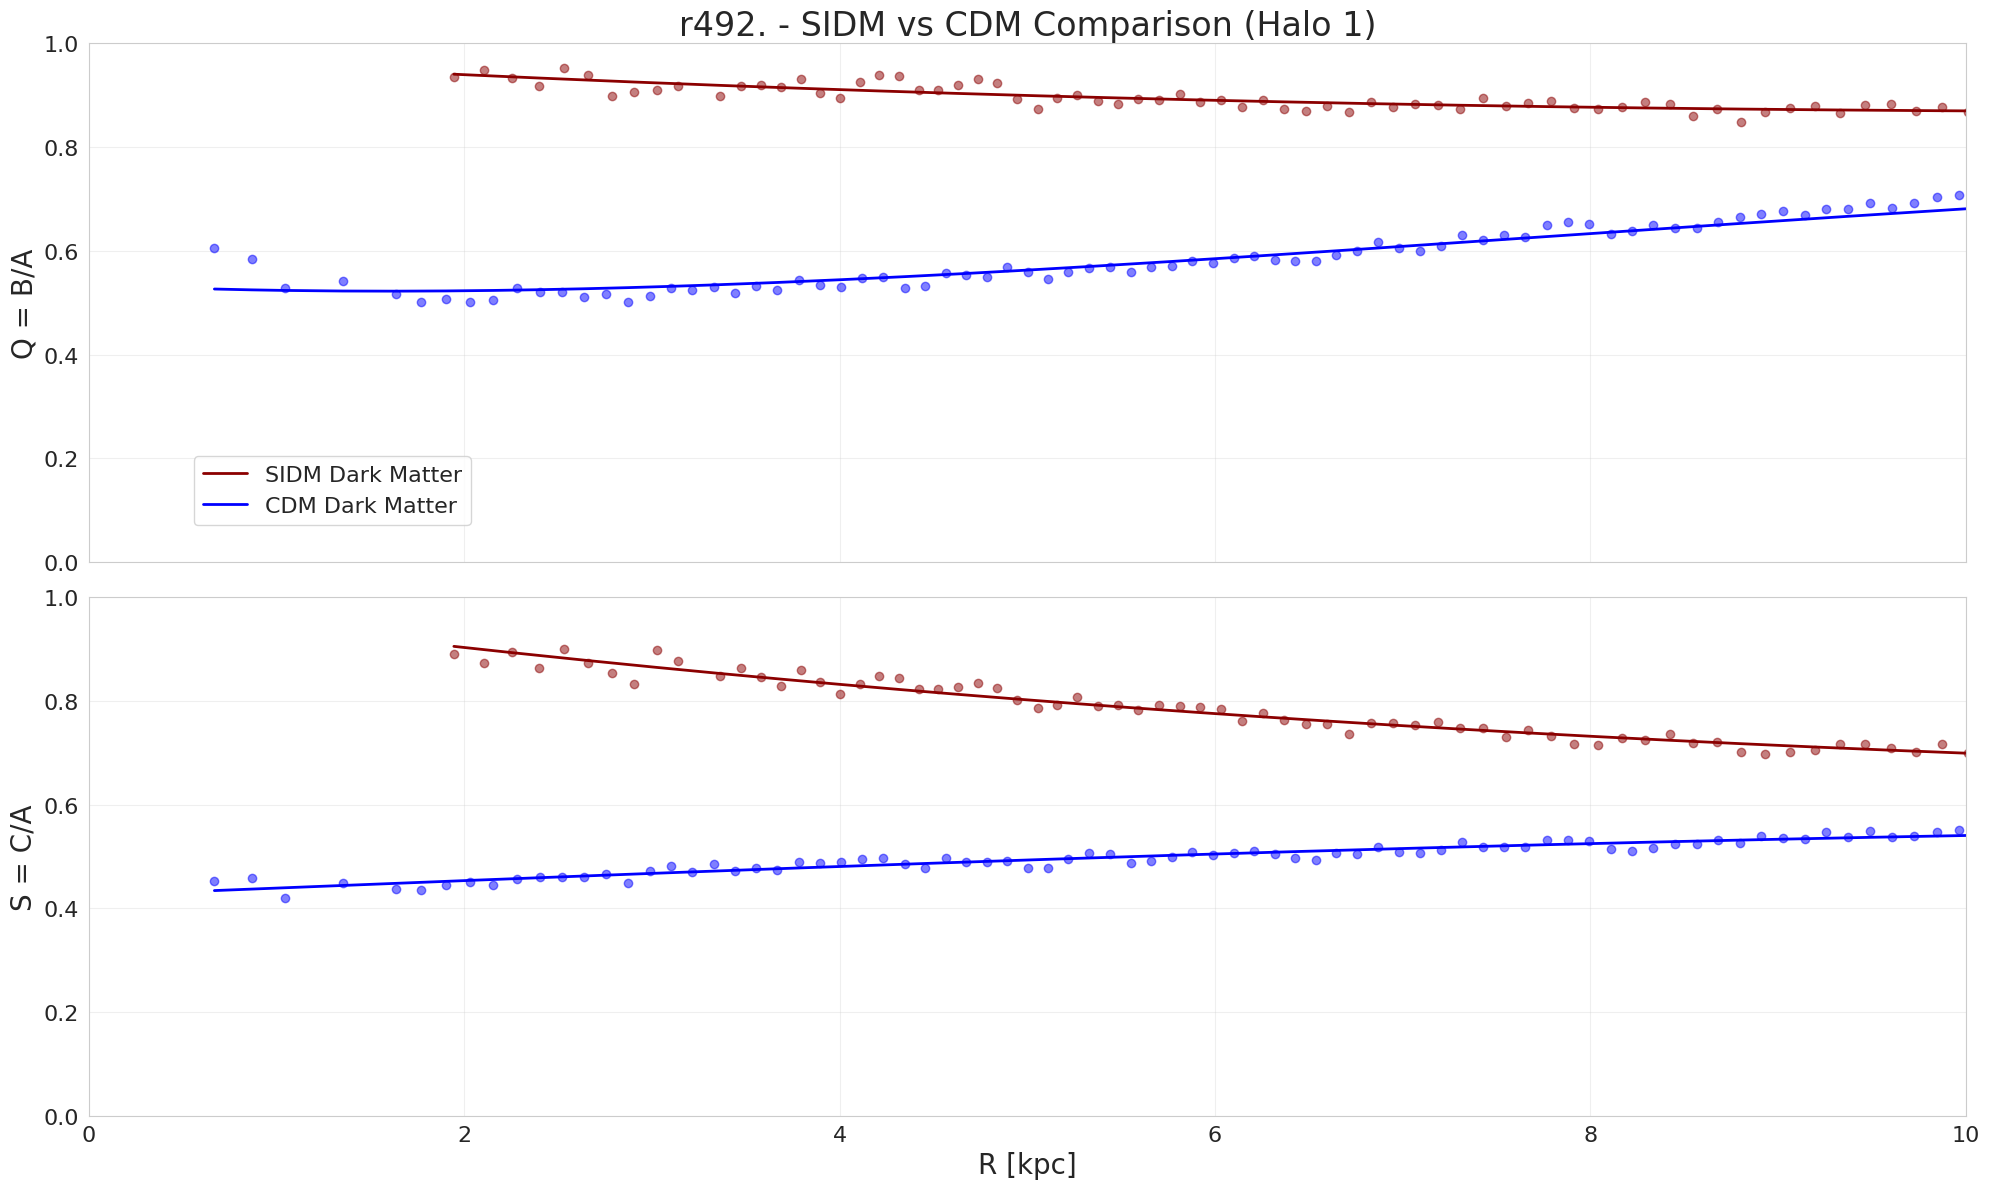

In [36]:

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

feedback_types = ['MerianSIDMad', 'MerianCDMad']

# Styling variables
FIGURE_SIZE = (20, 12)
LINEWIDTH = 2
FONTSIZE_TITLE = 24
FONTSIZE_LABEL = 20
FONTSIZE_TICK = 16
FONTSIZE_LEGEND = 16
ALPHA_RAW = 0.5
ALPHA_VLINE = 0.5

# Colors

COLOR_SIDM_DM = 'darkred'
COLOR_SIDM_STAR = 'red'
COLOR_CDM_DM = 'blue'
COLOR_CDM_STAR = 'cyan'

# Labels
LABEL_SIDM_DM = 'SIDM Dark Matter'
LABEL_SIDM_STAR = 'SIDM Stars'
LABEL_CDM_DM = 'CDM Dark Matter'
LABEL_CDM_STAR = 'CDM Stars'
LABEL_REFF = r'R$_{eff}$'
LABEL_BA = 'Q = B/A'
LABEL_CA = 'S = C/A'
LABEL_R_KPC = 'R [kpc]'

# Dictionary to store SimInfo for each feedback type
SimInfos = {}

SI = ''

# Load SimInfo for each feedback type
for feedback in feedback_types:
    pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            SimInfos[feedback] = pickle.load(f)
    else:
        print(f"Warning: {pickle_path} does not exist.")
for feedback in feedback_types:
    print(f'Feedback type: {feedback}')
    for sim in SimInfos[feedback]:
        print(sim)

#use sims
use_sim = ['r488.romulus25si2s50v35','r442.romulus25si2s50v35','r556.romulus25si2s50v35','r597.romulus25si2s50v35','r568.romulus25si2s50v35']



for sim_name in SimInfos['MerianSIDMad']:
    #split sim name into parts
    #eg r492.romulus25cvdXsec or r634.romulus25si2s50v35
    # if sim_name not in use_sim:
    #     continue
    sim = sim_name

    print(sim_name)
    print(f'Processing {sim} for SIDM and CDM comparison.')

    try:


        sidm_DMShapes = pickle.load(open(f'../../Data/{sim_name}.MerianSIDMad.DMShapes.pickle', 'rb'))
        #sidm_StarShapes = pickle.load(open(f'../../Data/{sim_name}.MerianSIDM.3DShapes.pickle', 'rb'))
        #sidm_Profiles = pickle.load(open(f'../../Data/{sim_name}.MerianSIDM.Profiles.pickle', 'rb'))

        cdm_DMShapes = pickle.load(open(f'../../Data/{sim}.MerianCDMad.DMShapes.pickle', 'rb'))
        #cdm_StarShapes = pickle.load(open(f'../../Data/{sim}.MerianCDM.3DShapes.pickle', 'rb'))
        #cdm_Profiles = pickle.load(open(f'../../Data/{sim}.MerianCDM.Profiles.pickle', 'rb'))

    except FileNotFoundError as e:
        print(f'Error loading pickle file: {e}')
        continue

    for hid in SimInfos['MerianSIDMad'][sim_name]['goodhalos']:
        try:
            # SIDM data
            sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca = sidm_DMShapes[(hid)]['rbins'], sidm_DMShapes[(hid)]['ba'], sidm_DMShapes[(hid)]['ca']
            #sidm_star_rbins, sidm_star_ba, sidm_star_ca = sidm_StarShapes[(hid)]['rbins'], sidm_StarShapes[(hid)]['ba'], sidm_StarShapes[(hid)]['ca']

            # CDM data
            cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca = cdm_DMShapes[(hid)]['rbins'], cdm_DMShapes[(hid)]['ba'], cdm_DMShapes[(hid)]['ca']
            #cdm_star_rbins, cdm_star_ba, cdm_star_ca = cdm_StarShapes[(hid)]['rbins'], cdm_StarShapes[(hid)]['ba'], cdm_StarShapes[(hid)]['ca']
            #print(sidm_mass_data)
            #sidm_sm = np.log10(sidm_mass_data[sim_name][str(hid)]['Mstar'])
            #cdm_sm = np.log10(cdm_mass_data[sim][str(hid)]['Mstar'])





            # Create the plot
            #f, ax2 = plt.subplots(1, 1, figsize=FIGURE_SIZE, sharex=True)
            f, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True)
            max_r = 10

            for ax in (ax1,ax2):
                ax.set_ylim([0, 1])
                ax.tick_params(which='both', labelsize=FONTSIZE_TICK)
                # Plot Reff lines with corresponding colors
                #ax.axvline(sidm_reffs[0], c=COLOR_SIDM_DM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'SIDM {LABEL_REFF}')
                #ax.axvline(cdm_reffs[0], c=COLOR_CDM_DM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'CDM {LABEL_REFF}')
                ax.grid(True, alpha=0.3)

            #ax = ax2
            #ax.set_xlim([0, max_r])


                            # Smooth and plot B/A using smooth_and_filter_data function
            sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca, sidm_dm_ba_smooth, sidm_dm_ca_smooth = smooth_and_filter_data(sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca)
            #sidm_star_rbins, sidm_star_ba, sidm_star_ca, sidm_star_ba_smooth, sidm_star_ca_smooth = smooth_and_filter_data(sidm_star_rbins, sidm_star_ba, sidm_star_ca)
            cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca, cdm_dm_ba_smooth, cdm_dm_ca_smooth = smooth_and_filter_data(cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca)
            #cdm_star_rbins, cdm_star_ba, cdm_star_ca, cdm_star_ba_smooth, cdm_star_ca_smooth = smooth_and_filter_data(cdm_star_rbins, cdm_star_ba, cdm_star_ca)

            #lot B/A
            ax1.scatter(sidm_dm_rbins, sidm_dm_ba, c=COLOR_SIDM_DM, alpha=ALPHA_RAW)
            #ax1.scatter(sidm_star_rbins, sidm_star_ba, c=COLOR_SIDM_STAR, alpha=ALPHA_RAW)
            ax1.scatter(cdm_dm_rbins, cdm_dm_ba, c=COLOR_CDM_DM, alpha=ALPHA_RAW)
            #ax1.scatter(cdm_star_rbins, cdm_star_ba, c=COLOR_CDM_STAR, alpha=ALPHA_RAW)


            ax1.plot(sidm_dm_rbins, sidm_dm_ba_smooth(sidm_dm_rbins), c=COLOR_SIDM_DM, label=LABEL_SIDM_DM, lw=LINEWIDTH, ls='-')
            #ax1.plot(sidm_star_rbins, sidm_star_ba_smooth(sidm_star_rbins), c=COLOR_SIDM_STAR, label=LABEL_SIDM_STAR, lw=LINEWIDTH, ls='--')
            ax1.plot(cdm_dm_rbins, cdm_dm_ba_smooth(cdm_dm_rbins), c=COLOR_CDM_DM, label=LABEL_CDM_DM, lw=LINEWIDTH, ls='-')
            #ax1.plot(cdm_star_rbins, cdm_star_ba_smooth(cdm_star_rbins), c=COLOR_CDM_STAR, label=LABEL_CDM_STAR, lw=LINEWIDTH, ls='--')

            ax1.set_title(f'{sim}.{SI} - SIDM vs CDM Comparison (Halo {hid})', fontsize=FONTSIZE_TITLE)
            ax1.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), prop={'size': FONTSIZE_LEGEND})
            ax1.set_ylabel(LABEL_BA, fontsize=FONTSIZE_LABEL)

            #Plot C/A

            ax2.plot(sidm_dm_rbins, sidm_dm_ca_smooth(sidm_dm_rbins), c=COLOR_SIDM_DM, label=LABEL_SIDM_DM, lw=LINEWIDTH, ls='-')
            #ax2.plot(sidm_star_rbins, sidm_star_ca_smooth(sidm_star_rbins), c=COLOR_SIDM_STAR, label=LABEL_SIDM_STAR, lw=LINEWIDTH, ls='--')
            ax2.plot(cdm_dm_rbins, cdm_dm_ca_smooth(cdm_dm_rbins), c=COLOR_CDM_DM, label=LABEL_CDM_DM, lw=LINEWIDTH, ls='-')
            #ax2.plot(cdm_star_rbins, cdm_star_ca_smooth(cdm_star_rbins), c=COLOR_CDM_STAR, label=LABEL_CDM_STAR, lw=LINEWIDTH, ls='--')

            ax2.set_ylabel(LABEL_CA, fontsize=FONTSIZE_LABEL)
            ax2.set_xlabel(LABEL_R_KPC, fontsize=FONTSIZE_LABEL)

            #ax2.legend(loc='lower left', bbox_to_anchor=(0.05, 0.05), prop={'size': FONTSIZE_LEGEND})

            #scatter plot of raw data

            ax2.scatter(sidm_dm_rbins, sidm_dm_ca, c=COLOR_SIDM_DM, alpha=ALPHA_RAW)
            #ax2.scatter(sidm_star_rbins, sidm_star_ca, c=COLOR_SIDM_STAR, alpha=ALPHA_RAW)
            ax2.scatter(cdm_dm_rbins, cdm_dm_ca, c=COLOR_CDM_DM, alpha=ALPHA_RAW)
            #ax2.scatter(cdm_star_rbins, cdm_star_ca, c=COLOR_CDM_STAR, alpha=ALPHA_RAW)



            ax.set_xlim([0, max_r])

            #add stellar mass of sidm and cdm as text labeling the plot
            #ax2.text(0.05, 0.9, f'SIDM Stellar Mass: {sidm_sm:.2f}', transform=ax2.transAxes, fontsize=FONTSIZE_LABEL, color='darkred')
            #ax2.text(0.05, 0.85, f'CDM Stellar Mass: {cdm_sm:.2f}', transform=ax2.transAxes, fontsize=FONTSIZE_LABEL, color='darkblue')

            #ax2.set_title(f'{sim}{SI} - Halo {hid}', fontsize=FONTSIZE_TITLE)

            # Create new folder for saving figures
            os.makedirs('../../Figures/3DShapes/SIDM_CDM_Comparison/', exist_ok=True)

            plt.tight_layout()
            #plt.savefig(f'../../Figures/3DShapes/SIDM_CDM_Comparison/Shapes.{sim}{SI}.SIDM_vs_CDM.{hid}.png')
            #plt.close()

        except Exception as e:
            print(f"An error occurred during processing halo {hid} in {sim}: {e}")
            print(traceback.format_exc())


print("Processing complete.")

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

feedback_types = ['MerianSIDM', 'MerianCDM']

# Dictionary to store SimInfo for each feedback type
SimInfos = {}

# Load SimInfo for each feedback type
for feedback in feedback_types:
    pickle_path = f'../PickleFiles/SimulationInfo.{feedback}.pickle'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            SimInfos[feedback] = pickle.load(f)
    else:
        print(f"Warning: {pickle_path} does not exist.")

# Process each SIDM simulation and compare with corresponding CDM simulation
# Process each SIDM simulation and compare with corresponding CDM simulation
for sim in SimInfos['MerianSIDM']:
    print(f'Processing {sim} for SIDM and CDM comparison.')

    try:
        # Load necessary data for SIDM
        sidm_masspath = f'../../Data/BasicData/MerianSIDM.Masses.pickle'
        cdm_masspath = f'../../Data/BasicData/MerianCDM.Masses.pickle'

        if os.path.exists(sidm_masspath) and os.path.exists(cdm_masspath):
            with open(sidm_masspath, 'rb') as f:
                sidm_mass_data = pickle.load(f)
            with open(cdm_masspath, 'rb') as f:
                cdm_mass_data = pickle.load(f)

        sidm_DMShapes = pickle.load(open(f'../../Data/{sim}.MerianSIDM.DMShapes.pickle', 'rb'))
        sidm_StarShapes = pickle.load(open(f'../../Data/{sim}.MerianSIDM.3DShapes.pickle', 'rb'))
        sidm_Profiles = pickle.load(open(f'../../Data/{sim}.MerianSIDM.Profiles.pickle', 'rb'))

        cdm_DMShapes = pickle.load(open(f'../../Data/{sim}.MerianCDM.DMShapes.pickle', 'rb'))
        cdm_StarShapes = pickle.load(open(f'../../Data/{sim}.MerianCDM.3DShapes.pickle', 'rb'))
        cdm_Profiles = pickle.load(open(f'../../Data/{sim}.MerianCDM.Profiles.pickle', 'rb'))

    except FileNotFoundError as e:
        print(f'Error loading pickle file: {e}')
        continue

    for hid in SimInfos['MerianSIDM'][sim]['goodhalos']:
        try:
            # SIDM data
            sidm_dm_rbins, sidm_dm_ba, sidm_dm_ca = sidm_DMShapes[str(hid)]['rbins'], sidm_DMShapes[str(hid)]['ba'], sidm_DMShapes[str(hid)]['ca']
            sidm_star_rbins, sidm_star_ba, sidm_star_ca = sidm_StarShapes[str(hid)]['rbins'], sidm_StarShapes[str(hid)]['ba'], sidm_StarShapes[str(hid)]['ca']

            # CDM data
            cdm_dm_rbins, cdm_dm_ba, cdm_dm_ca = cdm_DMShapes[str(hid)]['rbins'], cdm_DMShapes[str(hid)]['ba'], cdm_DMShapes[str(hid)]['ca']
            cdm_star_rbins, cdm_star_ba, cdm_star_ca = cdm_StarShapes[str(hid)]['rbins'], cdm_StarShapes[str(hid)]['ba'], cdm_StarShapes[str(hid)]['ca']

            sidm_sm = np.log10(sidm_mass_data[sim][str(hid)]['Mstar'])
            cdm_sm = np.log10(cdm_mass_data[sim][str(hid)]['Mstar'])

            if len(sidm_dm_rbins) > 0 and len(sidm_star_rbins) > 0 and len(cdm_dm_rbins) > 0 and len(cdm_star_rbins) > 0:
                sidm_reffs = []
                cdm_reffs = []
                for angle in sidm_Profiles[str(hid)]:
                    try:
                        sidm_reffs.append(sidm_Profiles[str(hid)][angle]['Reff'])
                        cdm_reffs.append(cdm_Profiles[str(hid)][angle]['Reff'])
                    except IndexError:
                        print(f'IndexError angle {angle} for halo {hid} in {sim}')
                    break
                
                # Styling variables
                FIGURE_SIZE = (12, 10)
                LINEWIDTH = 2
                FONTSIZE_TITLE = 24
                FONTSIZE_LABEL = 16
                FONTSIZE_TICK = 12
                FONTSIZE_LEGEND = 12
                ALPHA_RAW = 0.3
                ALPHA_VLINE = 0.5
                
                # Colors
                COLOR_SIDM = 'red'
                COLOR_CDM = 'blue'
                
                # Labels
                LABEL_SIDM = 'SIDM'
                LABEL_CDM = 'CDM'
                LABEL_REFF = r'R$_{eff}$'
                LABEL_BA = 'Q = B/A'
                LABEL_CA = 'S = C/A'
                LABEL_R_KPC = 'R [kpc]'
                
                # Smoothing parameters
                SMOOTH_SIGMA = 6
                
                def gaussian_smooth(x, y, sigma):
                    x_smooth = np.linspace(x.min(), x.max(), 500)
                    y_smooth = gaussian_filter1d(np.interp(x_smooth, x, y), sigma)
                    return interp1d(x_smooth, y_smooth, bounds_error=False, fill_value="extrapolate")
                
                # Create the plot
                fig, axs = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True)
                axs = axs.flatten()
                max_r = max(3.1 * sidm_reffs[0], 3.1 * cdm_reffs[0])
                
                for ax in axs.flatten():
                    ax.set_xlim([0, max_r])
                    ax.set_ylim([0, 1])
                    ax.tick_params(which='both', labelsize=FONTSIZE_TICK)
                    ax.grid(True, alpha=0.3)
                
                # Plot Dark Matter B/A
                axs[0].plot(sidm_dm_rbins, sidm_dm_ba, c=COLOR_SIDM, label=f'{LABEL_SIDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                axs[0].plot(cdm_dm_rbins, cdm_dm_ba, c=COLOR_CDM, label=f'{LABEL_CDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                
                sidm_dm_ba_smooth = gaussian_smooth(sidm_dm_rbins, sidm_dm_ba, SMOOTH_SIGMA)
                cdm_dm_ba_smooth = gaussian_smooth(cdm_dm_rbins, cdm_dm_ba, SMOOTH_SIGMA)
                
                axs[0].plot(sidm_dm_rbins, sidm_dm_ba_smooth(sidm_dm_rbins), c=COLOR_SIDM, label=LABEL_SIDM, lw=LINEWIDTH, ls='-')
                axs[0].plot(cdm_dm_rbins, cdm_dm_ba_smooth(cdm_dm_rbins), c=COLOR_CDM, label=LABEL_CDM, lw=LINEWIDTH, ls='-')
                #axs[0].set_title('Dark Matter B/A', fontsize=FONTSIZE_TITLE)
                axs[0].set_ylabel(LABEL_BA, fontsize=FONTSIZE_LABEL)
                axs[0].legend(loc='lower left', fontsize=FONTSIZE_LEGEND)
                
                # Plot Dark Matter C/A
                axs[1].plot(sidm_dm_rbins, sidm_dm_ca, c=COLOR_SIDM, label=f'{LABEL_SIDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                axs[1].plot(cdm_dm_rbins, cdm_dm_ca, c=COLOR_CDM, label=f'{LABEL_CDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                
                sidm_dm_ca_smooth = gaussian_smooth(sidm_dm_rbins, sidm_dm_ca, SMOOTH_SIGMA)
                cdm_dm_ca_smooth = gaussian_smooth(cdm_dm_rbins, cdm_dm_ca, SMOOTH_SIGMA)
                
                axs[1].plot(sidm_dm_rbins, sidm_dm_ca_smooth(sidm_dm_rbins), c=COLOR_SIDM, label=LABEL_SIDM, lw=LINEWIDTH, ls='-')
                axs[1].plot(cdm_dm_rbins, cdm_dm_ca_smooth(cdm_dm_rbins), c=COLOR_CDM, label=LABEL_CDM, lw=LINEWIDTH, ls='-')
                #axs[1].set_title('Dark Matter C/A', fontsize=FONTSIZE_TITLE)
                axs[1].set_ylabel(LABEL_CA, fontsize=FONTSIZE_LABEL)
                axs[1].set_xlabel(LABEL_R_KPC, fontsize=FONTSIZE_LABEL)
                axs[1].legend(loc='lower left', fontsize=FONTSIZE_LEGEND)
                print('SIDM',len(sidm_dm_rbins),sidm_dm_rbins[0],sidm_dm_rbins[-1])
                print('CDM',len(cdm_dm_rbins),cdm_dm_rbins[0],cdm_dm_rbins[-1])
                
                # # Plot Stellar B/A
                # axs[2].plot(sidm_star_rbins, sidm_star_ba, c=COLOR_SIDM, label=f'{LABEL_SIDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                # axs[2].plot(cdm_star_rbins, cdm_star_ba, c=COLOR_CDM, label=f'{LABEL_CDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                #
                # sidm_star_ba_smooth = gaussian_smooth(sidm_star_rbins, sidm_star_ba, SMOOTH_SIGMA)
                # cdm_star_ba_smooth = gaussian_smooth(cdm_star_rbins, cdm_star_ba, SMOOTH_SIGMA)
                #
                # axs[2].plot(sidm_star_rbins, sidm_star_ba_smooth(sidm_star_rbins), c=COLOR_SIDM, label=LABEL_SIDM, lw=LINEWIDTH, ls='-')
                # axs[2].plot(cdm_star_rbins, cdm_star_ba_smooth(cdm_star_rbins), c=COLOR_CDM, label=LABEL_CDM, lw=LINEWIDTH, ls='-')
                # axs[2].set_title('Stellar B/A', fontsize=FONTSIZE_TITLE)
                # axs[2].legend(loc='lower left', fontsize=FONTSIZE_LEGEND)
                #
                # # Plot Stellar C/A
                # axs[3].plot(sidm_star_rbins, sidm_star_ca, c=COLOR_SIDM, label=f'{LABEL_SIDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                # axs[3].plot(cdm_star_rbins, cdm_star_ca, c=COLOR_CDM, label=f'{LABEL_CDM} (raw)', lw=LINEWIDTH, ls=':', alpha=ALPHA_RAW)
                #
                # sidm_star_ca_smooth = gaussian_smooth(sidm_star_rbins, sidm_star_ca, SMOOTH_SIGMA)
                # cdm_star_ca_smooth = gaussian_smooth(cdm_star_rbins, cdm_star_ca, SMOOTH_SIGMA)
                #
                # axs[3].plot(sidm_star_rbins, sidm_star_ca_smooth(sidm_star_rbins), c=COLOR_SIDM, label=LABEL_SIDM, lw=LINEWIDTH, ls='-')
                # axs[3].plot(cdm_star_rbins, cdm_star_ca_smooth(cdm_star_rbins), c=COLOR_CDM, label=LABEL_CDM, lw=LINEWIDTH, ls='-')
                # axs[3].set_title('Stellar C/A', fontsize=FONTSIZE_TITLE)
                # axs[3].set_xlabel(LABEL_R_KPC, fontsize=FONTSIZE_LABEL)
                # axs[3].legend(loc='lower left', fontsize=FONTSIZE_LEGEND)
                
                # Add Reff lines to all subplots
                #for ax in axs.flatten():
                for i in range(1, 4):
                    ax.axvline(sidm_reffs[0]*i, c=COLOR_SIDM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'{LABEL_SIDM} {LABEL_REFF}')
                    ax.axvline(cdm_reffs[0]*i, c=COLOR_CDM, alpha=ALPHA_VLINE, linestyle=':', lw=LINEWIDTH, label=f'{LABEL_CDM} {LABEL_REFF}')
                    #add line at .5kpc
                ax.axvline(.5, c='k', alpha=ALPHA_VLINE, linestyle='--', lw=LINEWIDTH, label='0.5 kpc')
                #get stellar mass from mass data
                sidm_sm = np.log10(sidm_mass_data[sim][str(hid)]['Mstar'])
                cdm_sm = np.log10(cdm_mass_data[sim][str(hid)]['Mstar'])
                
                plt.suptitle(f'{sim} - SIDM M* = {sidm_sm:.1f} vs CDM M* = {cdm_sm:.1f} Comparison (Halo {hid})' , fontsize=FONTSIZE_TITLE)
                plt.tight_layout()
                #plt.savefig(f'../../Figures/3DShapes/SIDM_CDM_Comparison/Shapes.{sim}.SIDM_vs_CDM.{hid}.png')

        except Exception as e:
            print(f"An error occurred during processing halo {hid} in {sim}: {e}")

print("Processing complete.")